# Possible to-do's and discussion points:
1. [Which annotations to keep?](#different-polymorphism-annotations)
2. [Should we treshold based on the total allele number?](#distribution-across-the-genes)

# GonmAD analysis
## Library import

In [1]:
from pathlib import Path
import os
import pandas

In [2]:
from Bio import AlignIO
from Bio.Seq import Seq
from Bio.SeqUtils import seq1

In [3]:
from matplotlib import pyplot
import matplotlib
%matplotlib inline
matplotlib.style.use("ggplot")
matplotlib.rcParams["figure.figsize"] = (10, 10)

In [4]:
import plotly.express as px

## Importing the files
The raw files come in two sets. One is from GnomAD v3 and the other from GonAD v2. The second is present as a backup if the mapping to the protein sequence from v3 fails.

In [5]:
_folder_path = Path() / "Raw_data"
_raw_files = [x for x in os.listdir(_folder_path) if os.path.isfile(_folder_path / x)]
_alternative_raw = [file for file in _raw_files if "2.1.1" in file]
_raw_files = list(set(_raw_files) - set(_alternative_raw))
print(*_raw_files, sep="\n")

gnomAD_v3.1.1_ENSG00000186038_2021_08_25_17_57_43_5HT3E.csv
gnomAD_v3.1.1_ENSG00000022355_2021_08_25_17_45_26_GABRA1.csv
gnomAD_v3.1.1_ENSG00000163288_2021_08_25_17_51_16_GABRB1.csv
gnomAD_v3.1.1_ENSG00000102287_2021_08_25_17_51_00_GABRE.csv
gnomAD_v3.1.2_ENSG00000174343_2021_10_26_19_00_26_CHRNA9.csv
gnomAD_v3.1.1_ENSG00000138435_2021_08_26_22_09_48_CHRNA1.csv
gnomAD_v3.1.1_ENSG00000183185_2021_08_25_17_54_54_GABRR3.csv
gnomAD_v3.1.1_ENSG00000186297_2021_08_25_17_50_11_GABRA5.csv
gnomAD_v3.1.1_ENSG00000151834_2021_08_25_17_49_15_GABRA2.csv
gnomAD_v3.1.1_ENSG00000147434_2021_09_06_15_12_26_CHRNA6.csv
gnomAD_v3.1.2_ENSG00000147432_2021_10_26_19_03_23_CHRNB3.csv
gnomAD_v3.1.1_ENSG00000145451_2021_08_26_22_07_54_GLRA3.csv
gnomAD_v3.1.1_ENSG00000011677_2021_08_25_17_49_37_GABRA3.csv
gnomAD_v3.1.1_ENSG00000169684_2021_09_06_15_12_03_CHRNA5.csv
gnomAD_v3.1.1_ENSG00000182256_2021_08_25_17_52_30_GABRG3.csv
gnomAD_v3.1.1_ENSG00000101958_2021_08_26_22_07_30_GLRA2.csv
gnomAD_v3.1.1_ENSG0000012090

We import the files as pandas DataFrame and add a column in which we track the gene of interest.

In [6]:
data = []
for file in _raw_files:
    data.append(pandas.read_csv(_folder_path / file))
    data[-1]["Gene"] = file.split(".")[-2].split("_")[-1]
data_alternative = []
for file in _alternative_raw:
    data_alternative.append(pandas.read_csv(_folder_path / file))
    data_alternative[-1]["Gene"] = file.split(".")[-2].split("_")[-1]

In [7]:
data[0]

,Chromosome,Position,rsIDs,Reference,Alternate,Source,Filters - exomes,Filters - genomes,HGVS Consequence,Protein Consequence,...,Hemizygote Count Ashkenazi Jewish,Allele Count African/African-American,Allele Number African/African-American,Homozygote Count African/African-American,Hemizygote Count African/African-American,Allele Count European (non-Finnish),Allele Number European (non-Finnish),Homozygote Count European (non-Finnish),Hemizygote Count European (non-Finnish),Gene
0,3,184097455,rs1345471101,G,A,gnomAD Genomes,NaN,PASS,c.-75G>A,NaN,...,0,0,41450,0,0,0,68034,0,0,5HT3E
1,3,184097466,rs1373530692,G,A,gnomAD Genomes,NaN,PASS,c.-64G>A,NaN,...,0,1,41460,0,0,0,68040,0,0,5HT3E
2,3,184097476,rs1239387477,T,C,gnomAD Genomes,NaN,PASS,c.-54T>C,NaN,...,0,0,41454,0,0,1,68032,0,0,5HT3E
3,3,184097477,NaN,C,G,gnomAD Genomes,NaN,PASS,c.-53C>G,NaN,...,0,0,41442,0,0,1,68040,0,0,5HT3E
4,3,184097479,rs1334803717,G,C,gnomAD Genomes,NaN,PASS,c.-51G>C,NaN,...,0,0,41428,0,0,0,68020,0,0,5HT3E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,3,184106756,rs1246309858,T,TC,gnomAD Genomes,NaN,PASS,c.*69dup,NaN,...,0,0,41402,0,0,1,68022,0,0,5HT3E
603,3,184106761,rs536228198,C,A,gnomAD Genomes,NaN,PASS,c.*68C>A,NaN,...,0,1,41440,0,0,3,68030,0,0,5HT3E
604,3,184106761,rs536228198,C,G,gnomAD Genomes,NaN,PASS,c.*68C>G,NaN,...,0,4,41440,0,0,1,68030,0,0,5HT3E
605,3,184106762,NaN,C,G,gnomAD Genomes,NaN,PASS,c.*69C>G,NaN,...,0,0,41436,0,0,0,68030,0,0,5HT3E


Some columns are present only in a subset of files. We will keep them when joining the datasets, and introduce NaN where we have no data.

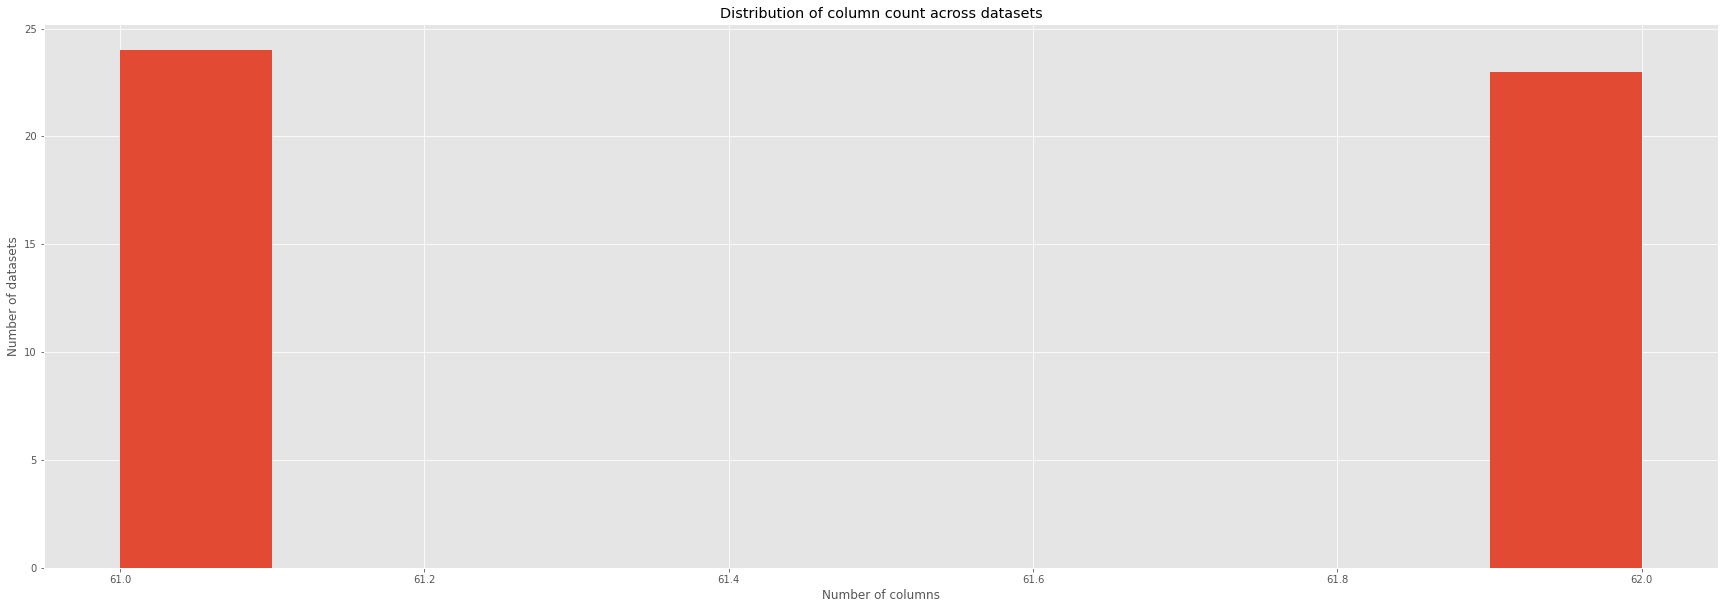

In [60]:
pyplot.hist([len(x.columns) for x in data])
pyplot.xlabel("Number of columns")
pyplot.ylabel("Number of datasets")
pyplot.title("Distribution of column count across datasets")
pyplot.show()

## Joining the datasets
We join both the main dataset and the alternative one.

In [9]:
dataset = pandas.concat(data, axis=0, join="outer", ignore_index=True)
dataset_alternative = pandas.concat(data_alternative, axis=0, join="outer", ignore_index=True)

In [10]:
dataset.shape

(28738, 62)

## Exploring the total dataset
### Different polymorphism annotations
For a complete description of the effect annotations see [the ensembl description](https://www.ensembl.org/info/genome/variation/prediction/predicted_data.html).
Only a subset of all the possible annotations is present. Here we focus only on the ones that result in a difference in the protein product. We collect the annotation labels into a list we can invoke later on.

In [11]:
dataset["VEP Annotation"].unique()

array(['5_prime_UTR_variant', 'synonymous_variant', 'missense_variant',
       'inframe_deletion', 'stop_gained', 'intron_variant', 'start_lost',
       'frameshift_variant', 'splice_region_variant',
       'splice_acceptor_variant', 'splice_donor_variant',
       '3_prime_UTR_variant', 'inframe_insertion',
       'stop_retained_variant', 'stop_lost', 'protein_altering_variant',
       nan], dtype=object)

In [12]:
_VEPs = ["missense_variant",
         "stop_gained",
         "splice_acceptor_variant",
         "splice_donor_variant",
         "frameshift_variant",
         "inframe_deletion",
         "inframe_insertion",
         "start_lost",
         "stop_lost",
         "protein_altering_variant"]

We see that the majority of the mutations of interest get classified into missense mutations (note that the visuals below only look at the labels of interest; though in the first graph the proportion is normalized to the size of the whole dataset, in the pie chart the total is equal to the number of the mutations of interest). As such, it might make sense to discuss if we would be better off disregarding all the other types of mutations just to make our life easier in terms of the analysis. In any event the proportions of different mutation types should probably be shown. 

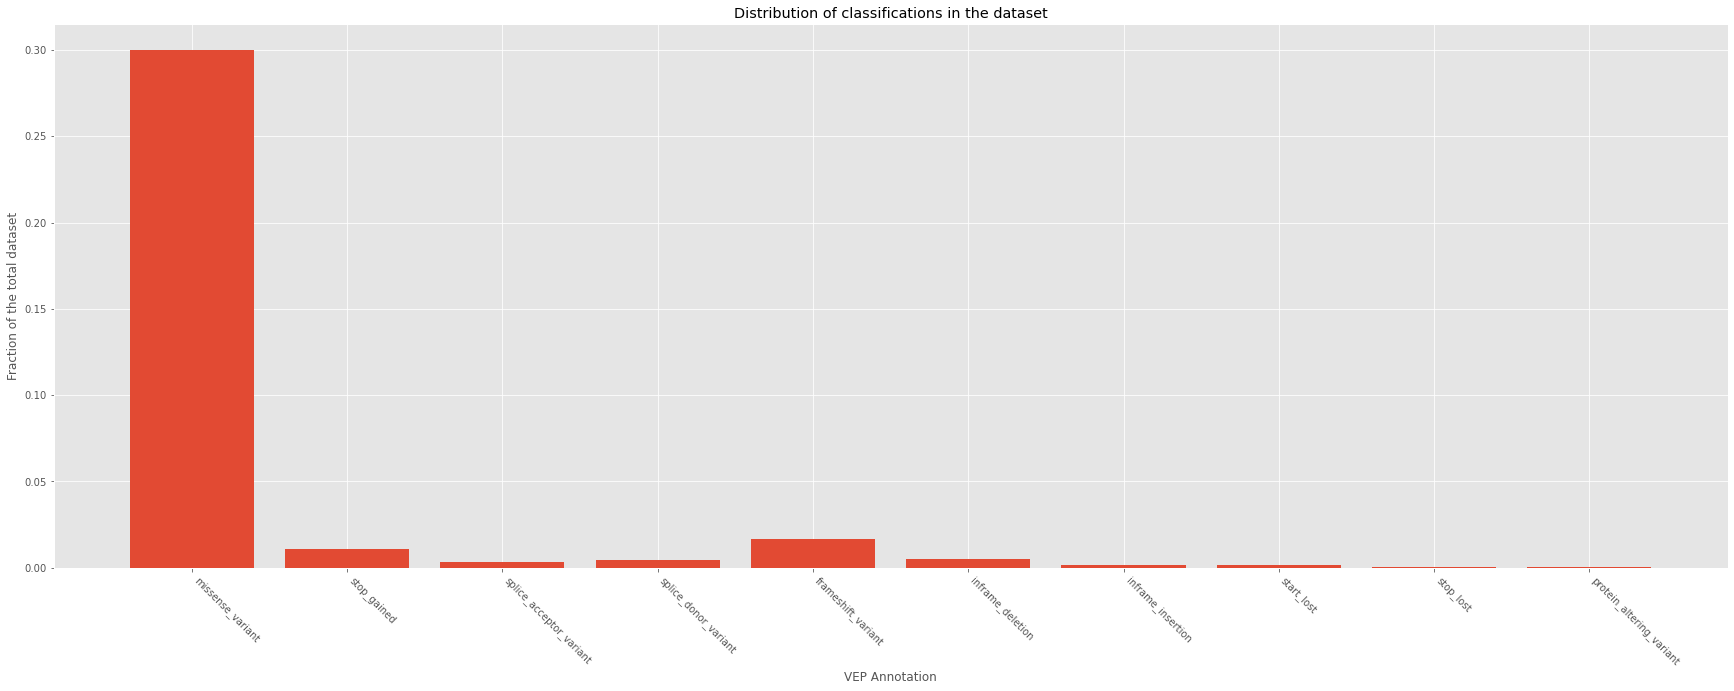

In [61]:
pyplot.bar(_VEPs, [sum(dataset["VEP Annotation"] == x)/dataset.shape[0]  for x in _VEPs])
pyplot.xticks(rotation=-45, horizontalalignment="left")
pyplot.xlabel("VEP Annotation")
pyplot.ylabel("Fraction of the total dataset")
pyplot.title("Distribution of classifications in the dataset")
pyplot.show()

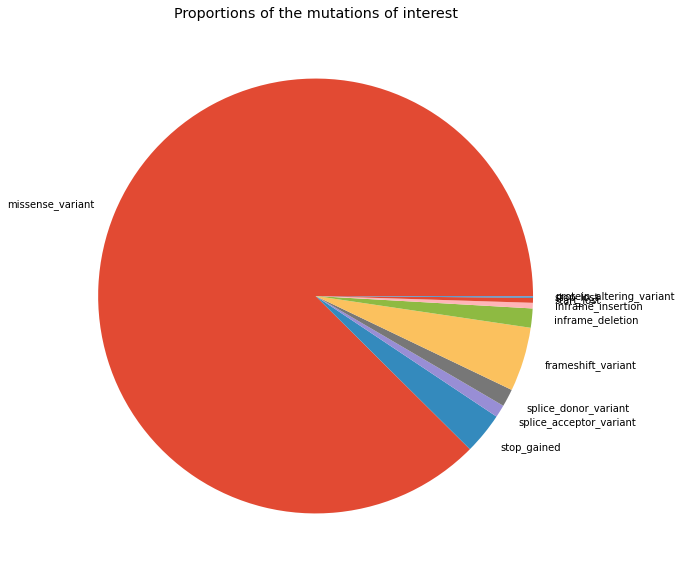

In [63]:
_counts = [sum(dataset["VEP Annotation"] == x)  for x in _VEPs]
_total = sum(_counts)
_counts = [x/_total for x in _counts]
pyplot.pie(_counts, labels=_VEPs, normalize=True)
pyplot.title("Proportions of the mutations of interest")
pyplot.show()

## Filtering

Before filtering anything else, we will discard all the data points where the total allele number deviates too much.

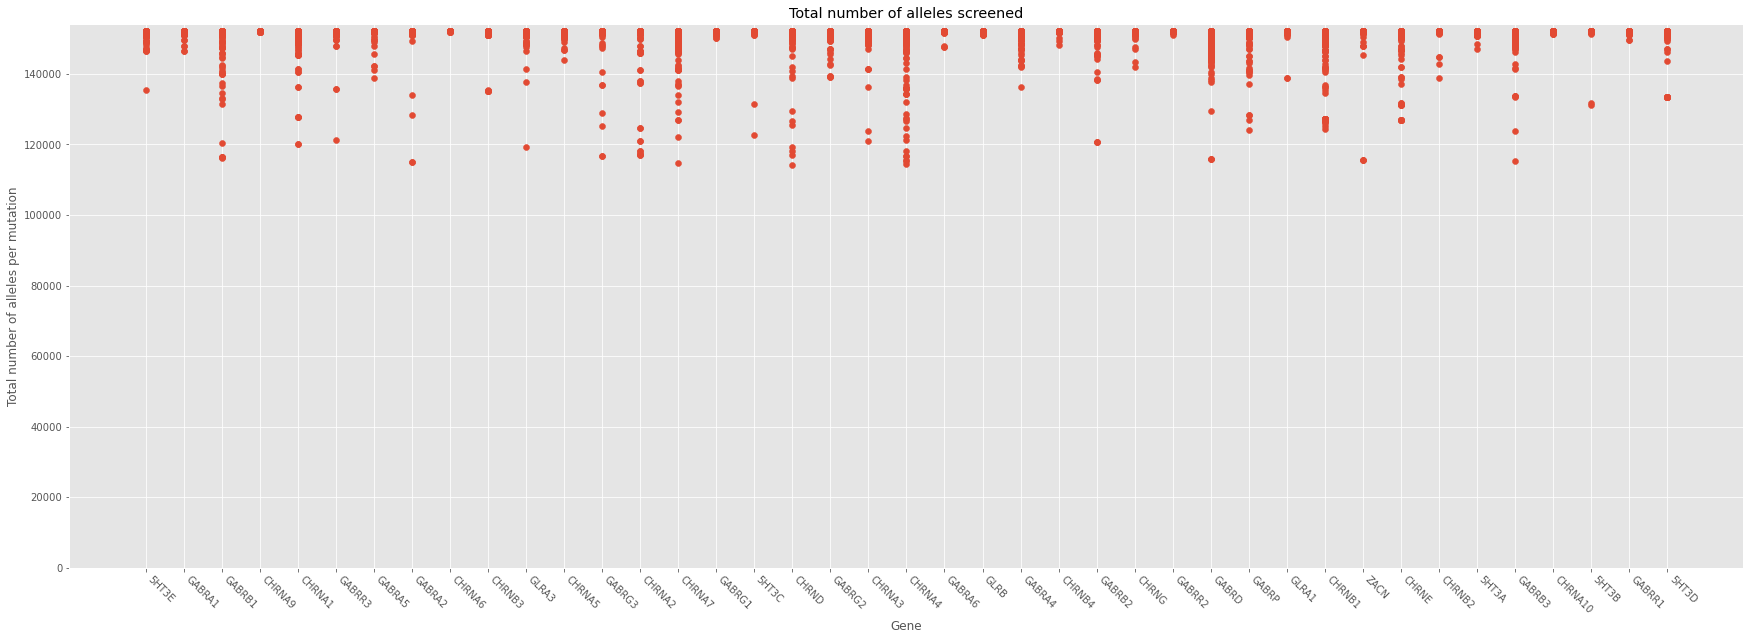

In [64]:
pyplot.scatter(dataset["Gene"], dataset["Allele Number"])
pyplot.xticks(rotation=-45, horizontalalignment="left")
pyplot.xlabel("Gene")
pyplot.ylabel("Total number of alleles per mutation")
pyplot.title("Total number of alleles screened")
ax = pyplot.gca()
ax.set_ylim([0, None])
pyplot.show()

In [16]:
_mean_af = dataset["Allele Number"].mean()
_std_af = dataset["Allele Number"].std()
print(f"Mean: {_mean_af}\nS. dev.: {_std_af}")

Mean: 148916.9469892099
S. dev.: 11639.162625345753


In [17]:
dataset = dataset[dataset.apply(lambda x: abs(x["Allele Number"] - _mean_af) < 3*_std_af, axis=1)]

Let's check again how the distribution looks like.

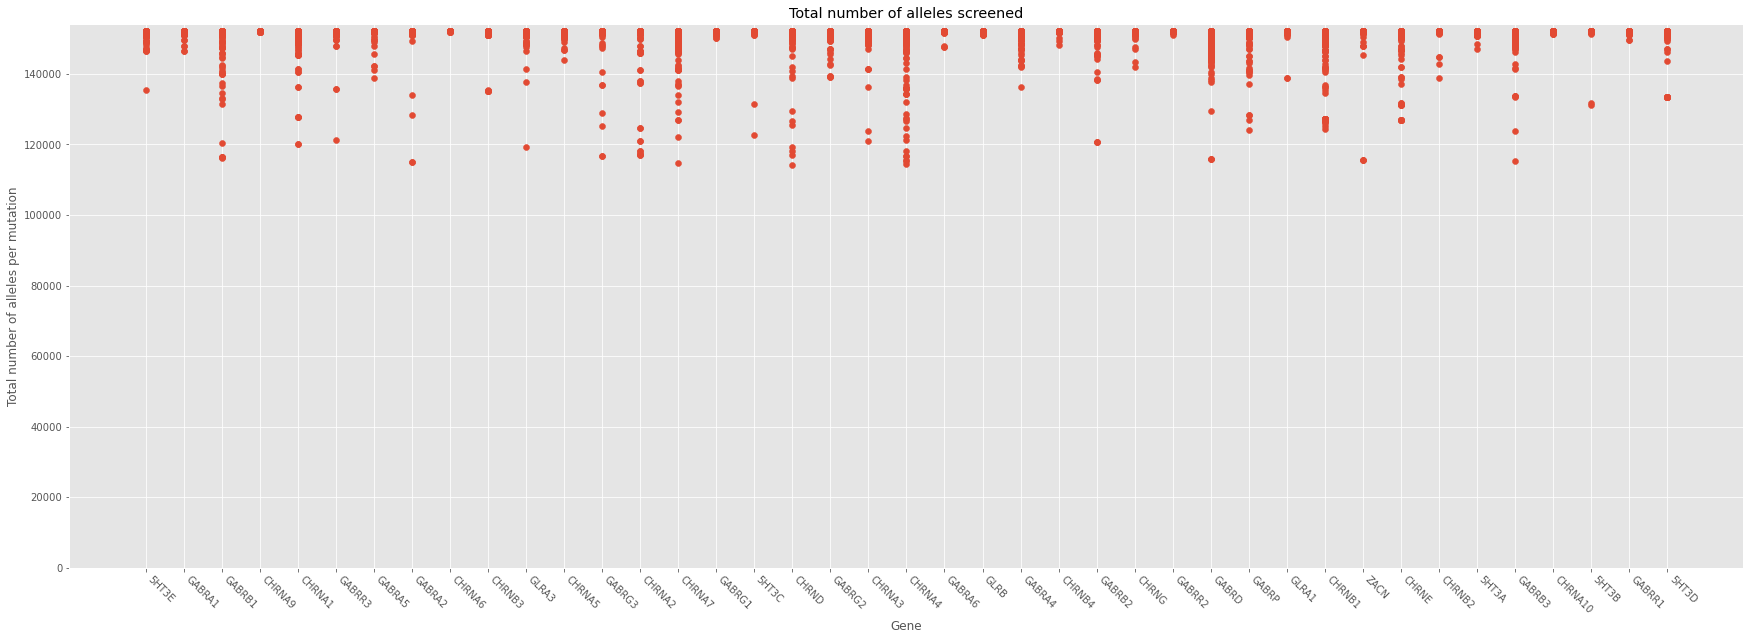

In [65]:
pyplot.scatter(dataset["Gene"], dataset["Allele Number"])
pyplot.xticks(rotation=-45, horizontalalignment="left")
pyplot.xlabel("Gene")
pyplot.ylabel("Total number of alleles per mutation")
pyplot.title("Total number of alleles screened")
ax = pyplot.gca()
ax.set_ylim([0, None])
pyplot.show()

We filter only for the GnomAD data.

In [19]:
dataset = dataset[dataset["Source"] == "gnomAD Genomes"]
dataset.reset_index(inplace=True)

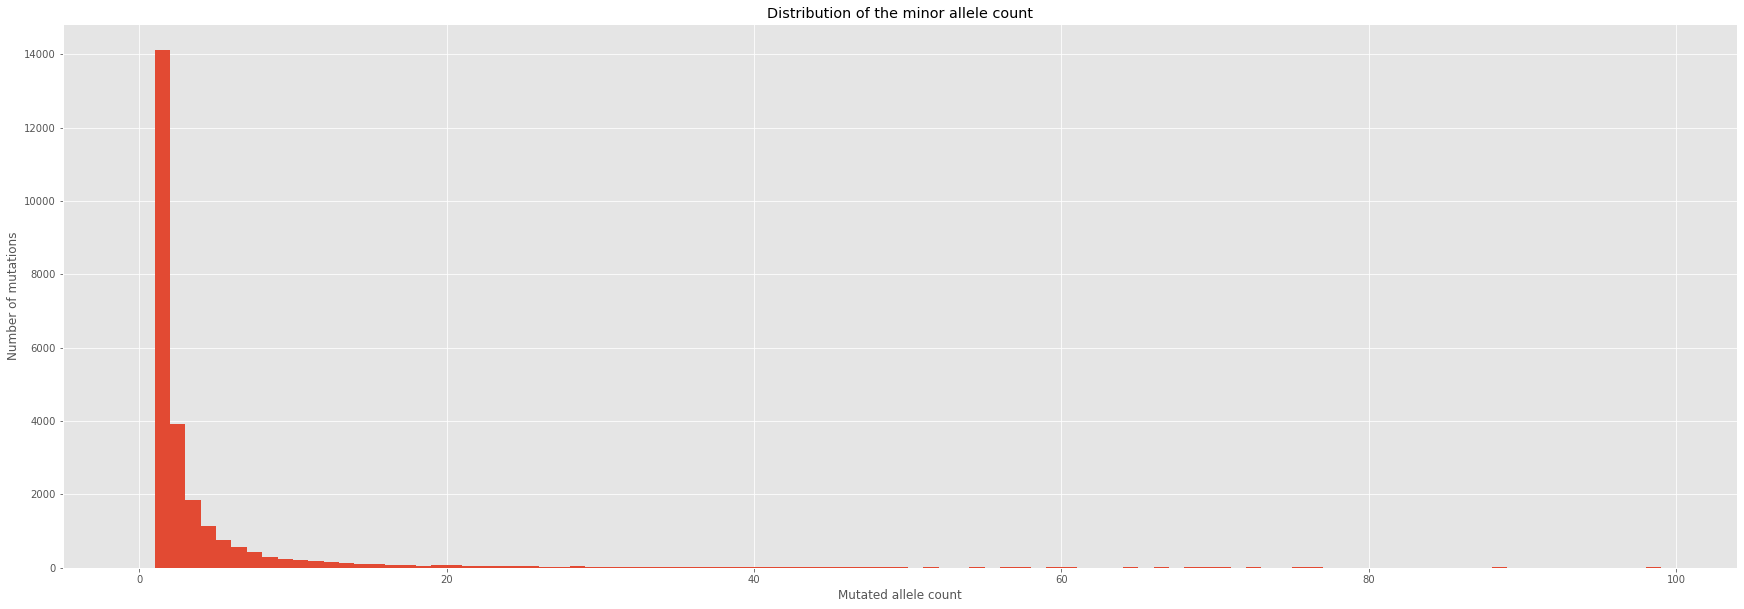

In [67]:
pyplot.hist(dataset["Allele Count"], bins=[x for x in range(0, 100)])
pyplot.xlabel("Mutated allele count")
pyplot.ylabel("Number of mutations")
pyplot.title("Distribution of the minor allele count")
pyplot.show()

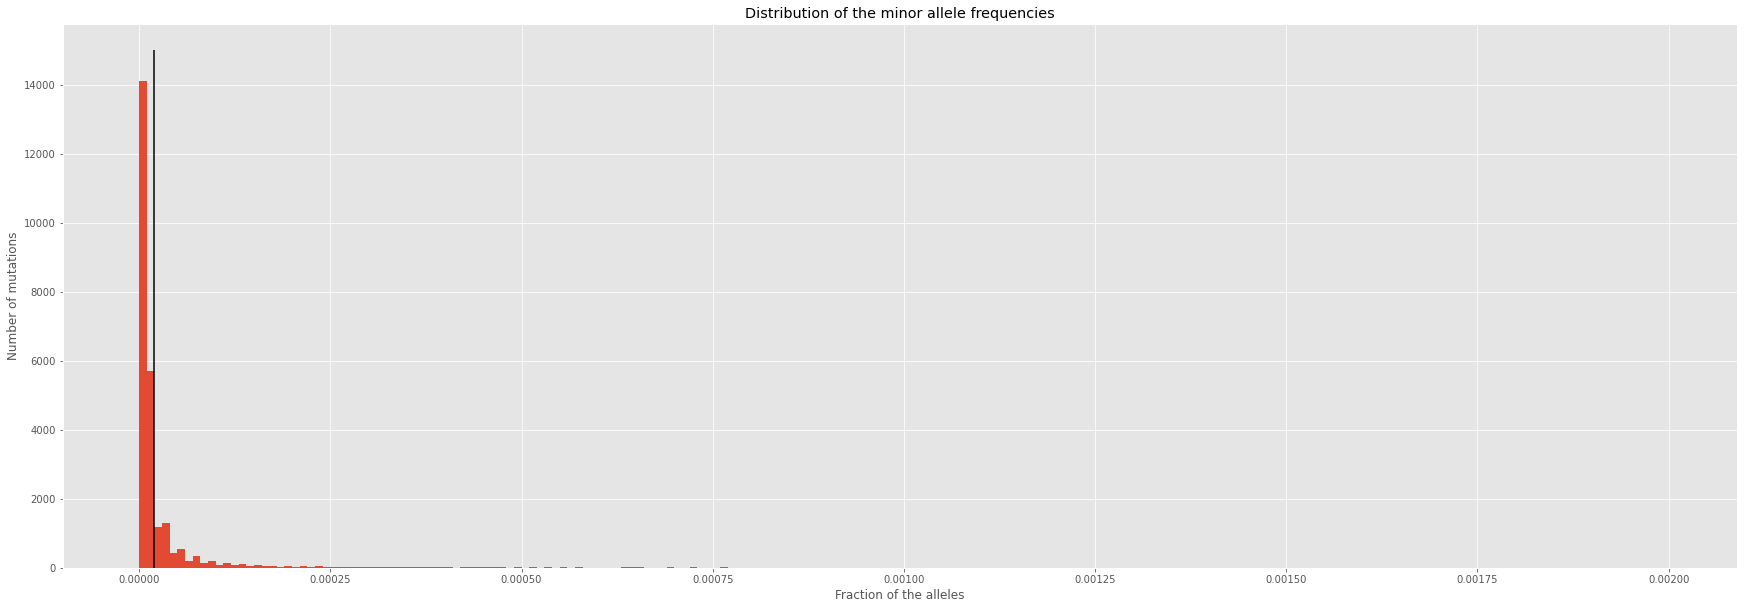

In [69]:
pyplot.hist(dataset["Allele Count"]/dataset["Allele Number"], bins=[x*0.00001 for x in range(0, 200)])
pyplot.xlabel("Fraction of the alleles")
pyplot.ylabel("Number of mutations")
pyplot.title("Distribution of the minor allele frequencies")
pyplot.vlines([0.00002], ymin=0, ymax=15000, colors="black")
pyplot.show()

For now we filter by including only variants present in at least 0.002 % of the population. The treshold is discussable, as the current one was chosen mainly just to perform some level of selection while also retaining a meaningful amount of data. Based on the majority of the sample sizes (see also below for a graphical depiction) the cutoff should in the majority of cases be in the range of 10 detected alleles.

We also retain just the columns of interest. Let's see the distribution of the annotations now.

In [22]:
subdata = dataset[dataset["Allele Count"]/dataset["Allele Number"] > 0.00002]
subdata = subdata[subdata["VEP Annotation"].isin(_VEPs)]
subdata

,index,Chromosome,Position,rsIDs,Reference,Alternate,Source,Filters - exomes,Filters - genomes,HGVS Consequence,...,Allele Count African/African-American,Allele Number African/African-American,Homozygote Count African/African-American,Hemizygote Count African/African-American,Allele Count European (non-Finnish),Allele Number European (non-Finnish),Homozygote Count European (non-Finnish),Hemizygote Count European (non-Finnish),Gene,Transcript
17,17,3,184097542.0,rs900016807,T,C,gnomAD Genomes,NaN,PASS,p.Trp5Arg,...,0.0,41458.0,0.0,0.0,0.0,68032.0,0.0,0.0,5HT3E,NaN
18,18,3,184097546.0,rs141876588,T,C,gnomAD Genomes,NaN,PASS,p.Phe6Ser,...,844.0,41444.0,12.0,0.0,2.0,68020.0,0.0,0.0,5HT3E,NaN
19,19,3,184097558.0,rs950229540,G,T,gnomAD Genomes,NaN,PASS,p.Arg10Ile,...,8.0,41460.0,0.0,0.0,0.0,68026.0,0.0,0.0,5HT3E,NaN
48,48,3,184100374.0,rs200567128,T,C,gnomAD Genomes,NaN,PASS,p.Met1?,...,0.0,41414.0,0.0,0.0,0.0,67988.0,0.0,0.0,5HT3E,NaN
51,51,3,184100391.0,rs779717629,T,A,gnomAD Genomes,NaN,PASS,p.Ser7Thr,...,1.0,41430.0,0.0,0.0,4.0,67992.0,0.0,0.0,5HT3E,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26821,28698,3,184038904.0,rs115389821,C,A,gnomAD Genomes,NaN,PASS,p.Leu382Met,...,922.0,41454.0,13.0,0.0,150.0,68044.0,0.0,0.0,5HT3D,NaN
26825,28702,3,184038913.0,rs761481633,C,T,gnomAD Genomes,NaN,PASS,p.Arg385Cys,...,0.0,41430.0,0.0,0.0,3.0,68032.0,0.0,0.0,5HT3D,NaN
26826,28703,3,184038914.0,rs6789754,G,A,gnomAD Genomes,NaN,PASS,p.Arg385His,...,32556.0,41340.0,12840.0,0.0,39424.0,67922.0,11396.0,0.0,5HT3D,NaN
26833,28710,3,184038952.0,rs377232617,G,A,gnomAD Genomes,NaN,PASS,p.Val398Ile,...,1.0,41436.0,0.0,0.0,3.0,68040.0,0.0,0.0,5HT3D,NaN


If we look at the distribution of mutations across the annotation labels as before, we see that the distribution has become even more skewed towards the missense variants.

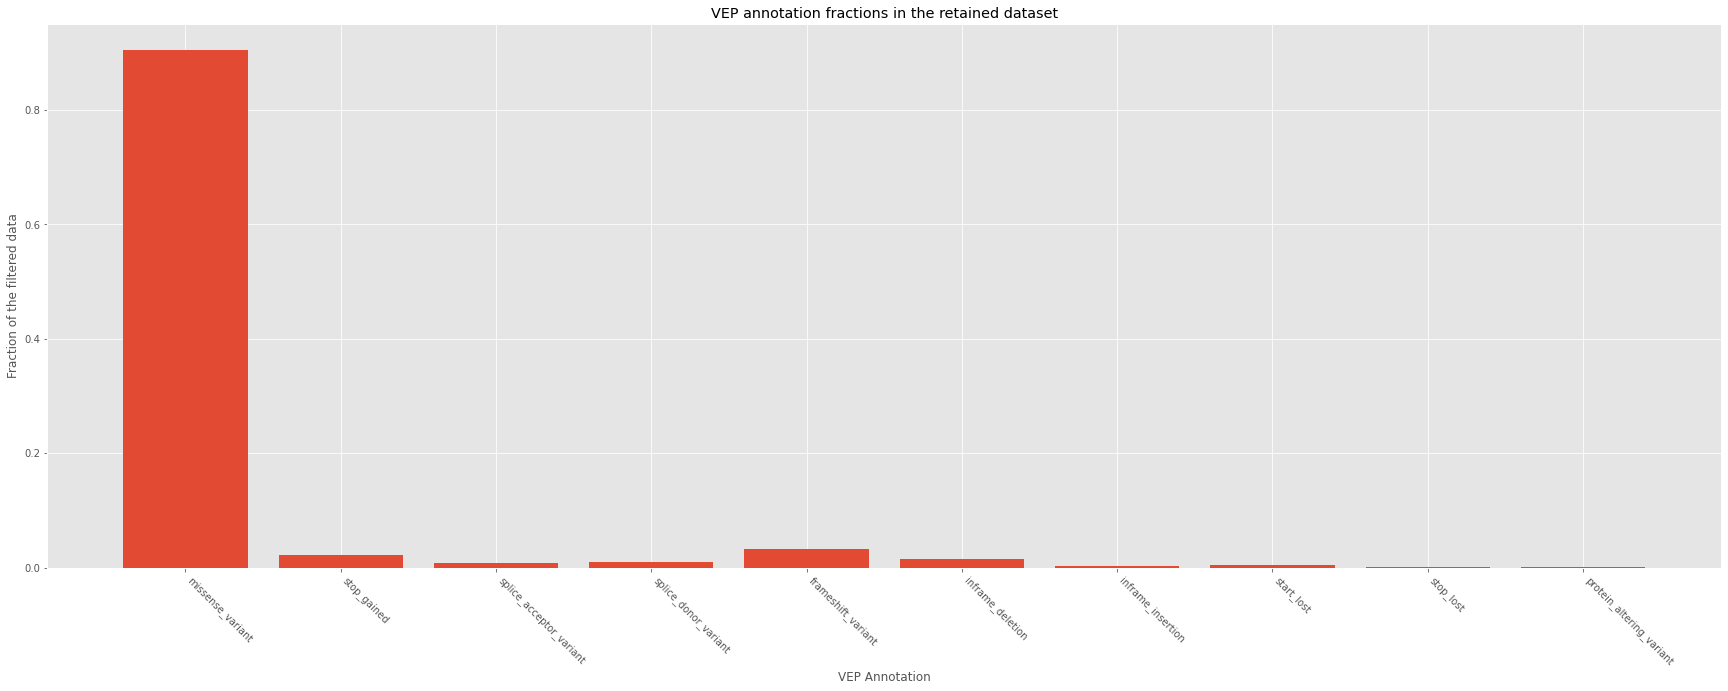

In [70]:
pyplot.bar(_VEPs, [sum(subdata["VEP Annotation"] == x)/subdata.shape[0]  for x in _VEPs])
pyplot.xticks(rotation=-45, horizontalalignment="left")
pyplot.xlabel("VEP Annotation")
pyplot.ylabel("Fraction of the filtered data")
pyplot.title("VEP annotation fractions in the retained dataset")
pyplot.show()

## Distribution across the genes
First we just look at the number of different polymorphisms detected for each gene.

In [24]:
matplotlib.rcParams["figure.figsize"] = (30, 10)

In [25]:
_genes = subdata["Gene"].unique()
_values = pandas.DataFrame({"Gene": _genes, "Value": [sum(subdata["Gene"] == x)/subdata.shape[0]  for x in _genes]})
_values.sort_values(by="Value", ascending=False, inplace=True, ignore_index=True)

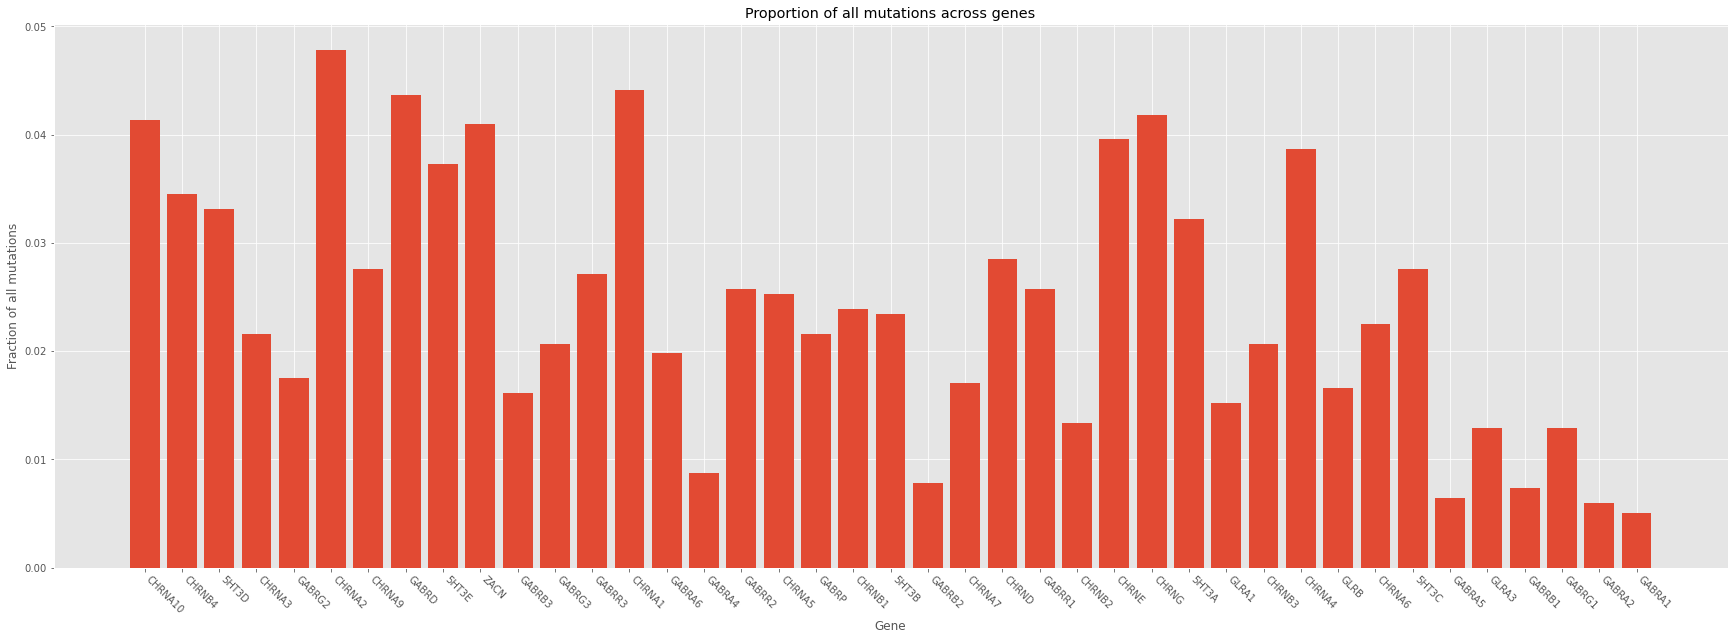

In [71]:
pyplot.bar(_values["Gene"], _values["Value"])
pyplot.xticks(rotation=-45, horizontalalignment="left")
pyplot.xlabel("Gene")
pyplot.ylabel("Fraction of all mutations")
pyplot.title("Proportion of all mutations across genes")
pyplot.show()

We might want to discard some samples where total allele number is lower than some set treshold, as these might become the possible outliers in later statistics.

Next we look at the allele counts across all the mutations for single genes to get a feeling for which genes drive the statistical power in our sample. 

In [27]:
_values["Allele Count"] = [sum(subdata["Allele Count"][subdata["Gene"] == x]) for x in _values["Gene"]]
_values.sort_values(by="Allele Count", ascending=False, inplace=True, ignore_index=True)

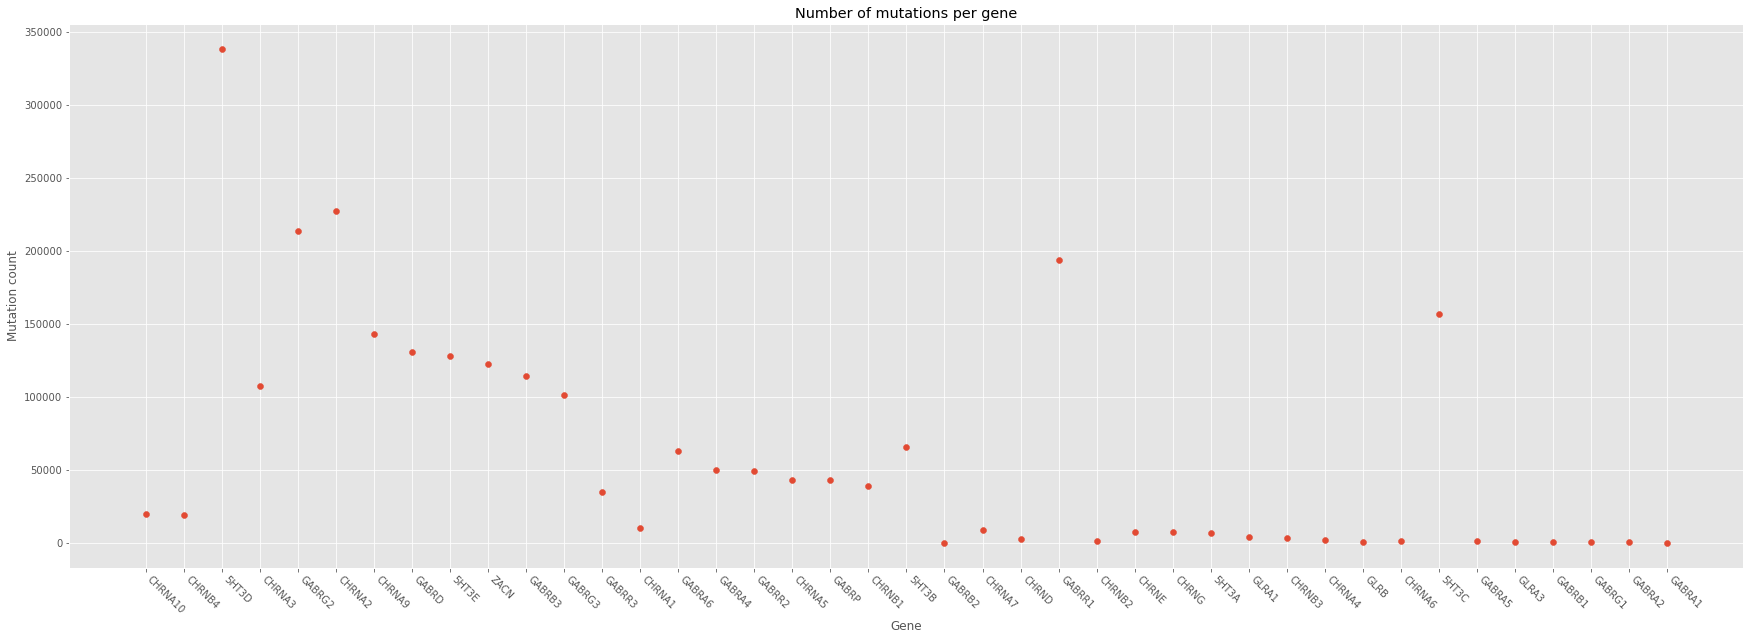

In [72]:
pyplot.scatter(_values["Gene"], _values["Allele Count"])
pyplot.xticks(rotation=-45, horizontalalignment="left")
pyplot.xlabel("Gene")
pyplot.ylabel("Mutation count")
pyplot.title("Number of mutations per gene")
pyplot.show()

## Extracting the AA number from missense variants
We extracted the numbering of amino acid from `Protein Sequence` column. Then we used UniProt for determining the lengths of all proteins and normalized the position of amino acids to the full protein lengths. For a more in-depth analysis we would need an alignment.

We then look at the relative positions of the mutations for each gene separately by plotting the histograms one by one.

In [29]:
missense = subdata[subdata["VEP Annotation"] == "missense_variant"]
missense["AA Number"] = missense["Protein Consequence"].str.extract(r"[a-zA-Z]([0-9]+)[a-zA-Z]").astype("int32")
missense.reset_index(inplace=True)

C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [30]:
missense["AA Relative"] = 0
# Lengths are taken from UniProt
lengths = {
    "GABRA3": 492,
    "GABRA1": 456,
    "CHRNA3": 505,
    "GABRP": 440,
    "CHRNA4": 627,
    "GLRA2": 452,
    "GABRE": 506,
    "GABRA4": 554, 
    "GLRB": 497,
    "GABRR2": 465,
    "GABRG2": 467,
    "CHRNA2": 529,
    "CHRNA1": 482,
    "GLRA3": 464,
    "GABRA6": 453,
    "GABRB2": 512,
    "GLRA1": 457,
    "GABRR1": 479,
    "CHRNA6": 494,
    "5HT3B": 441,
    "GABRA2": 451,
    "GABRG1": 465,
    "GABRB1": 474,
    "GABRB3": 473,
    "5HT3A": 478,
    "CHRNA5": 468,
    "5HT3C": 447,
    "GABRG3": 467,
    "GABRR3": 467,
    "5HT3E": 456,
    "5HT3D": 454,
    "GABRA5": 462,
    "ZACN": 412,
    "GABRD": 452,
    "GABRQ": 632,
    "CHRNE": 493,
    "CHRNB4": 498,
    "CHRNA10": 450,
    "CHRND": 517,
    "CHRNB3": 458,
    "CHRNB2": 502,
    "CHRNB1": 501,
    "CHRNA9": 479,
    "CHRNA7": 502,
    "CHRNG": 517,
}
for gene in missense["Gene"].unique():
    missense["AA Relative"][missense["Gene"] == gene] = missense["AA Number"][missense["Gene"] == gene] / lengths[gene]

C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda\lib\site-packages\pandas\core\generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

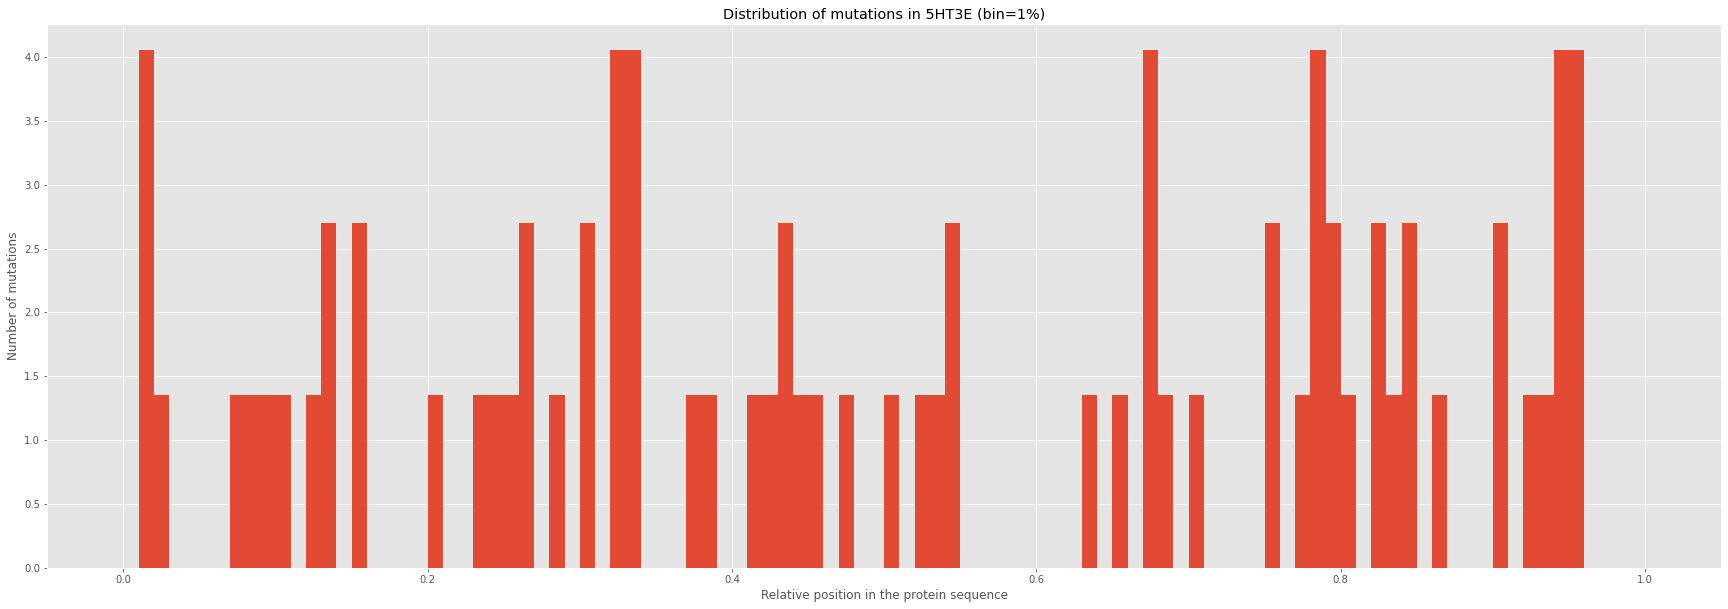

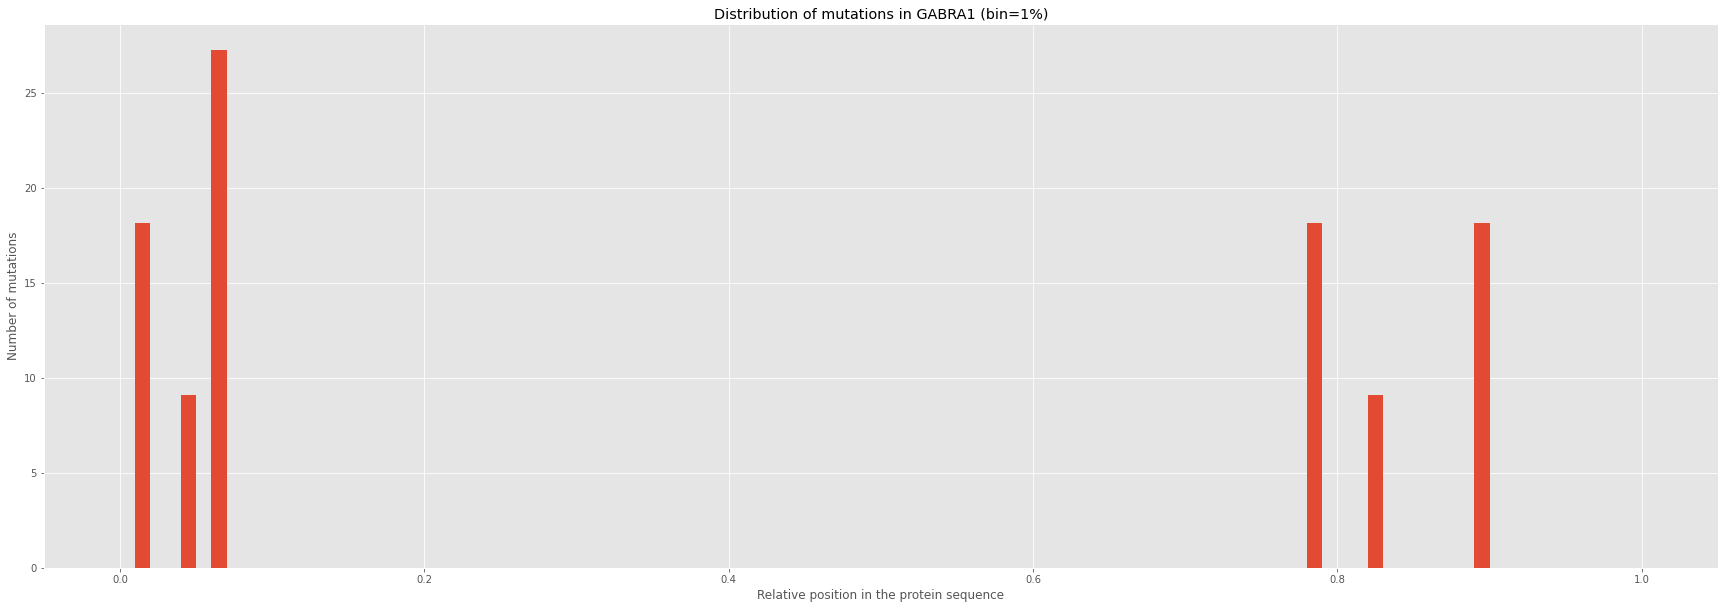

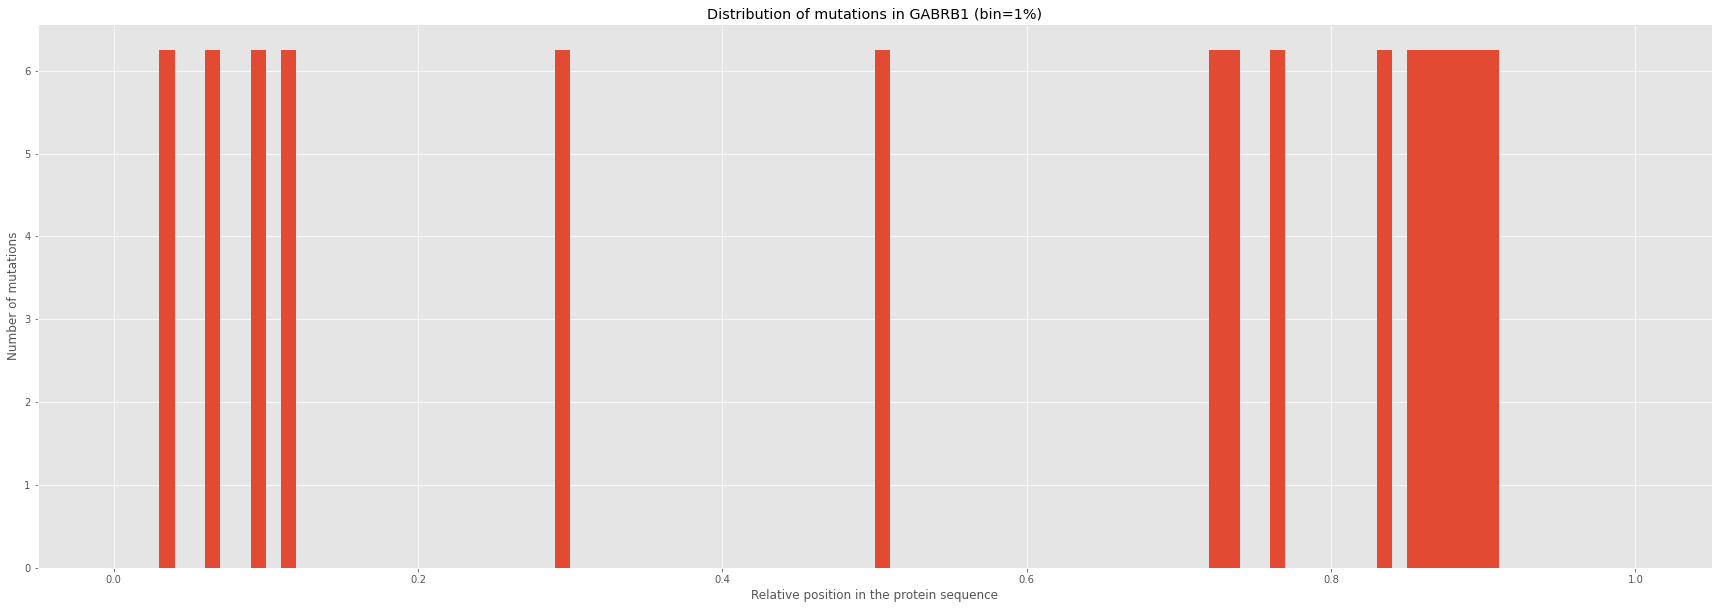

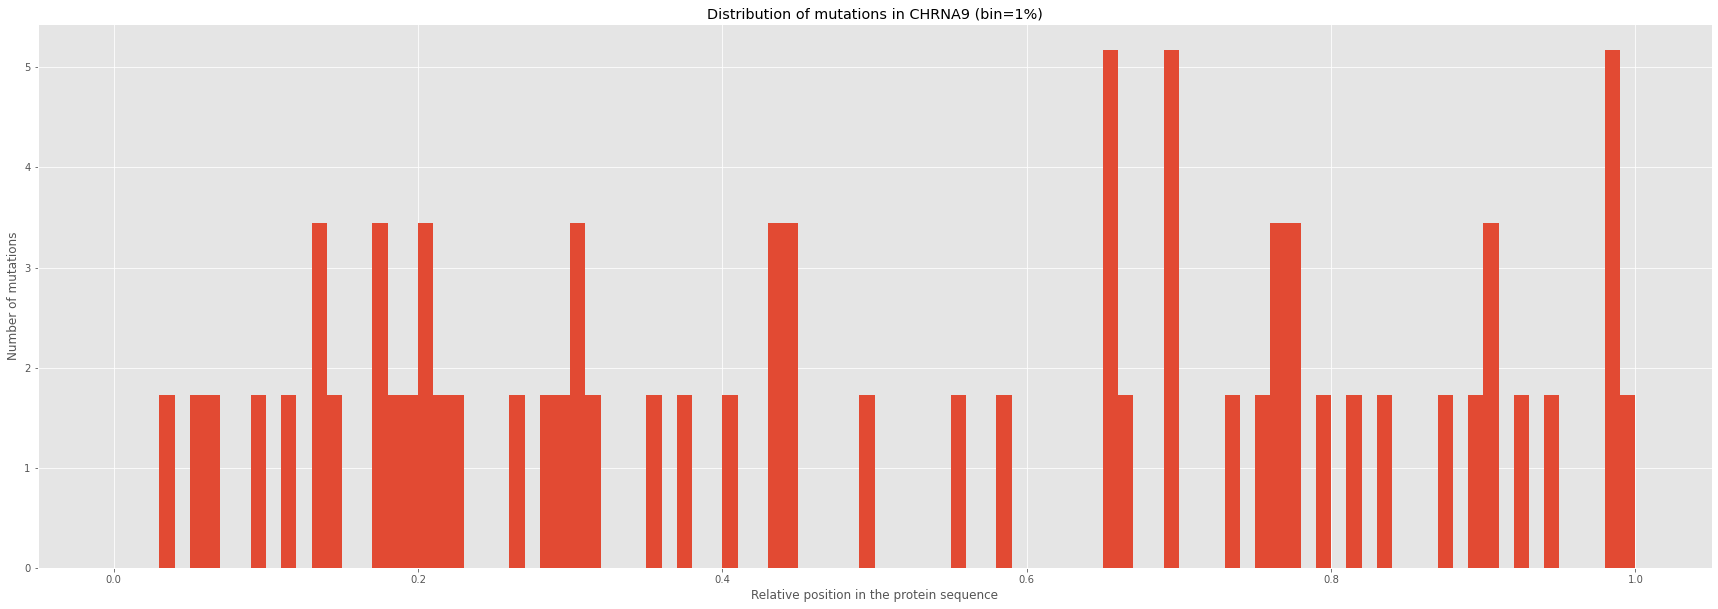

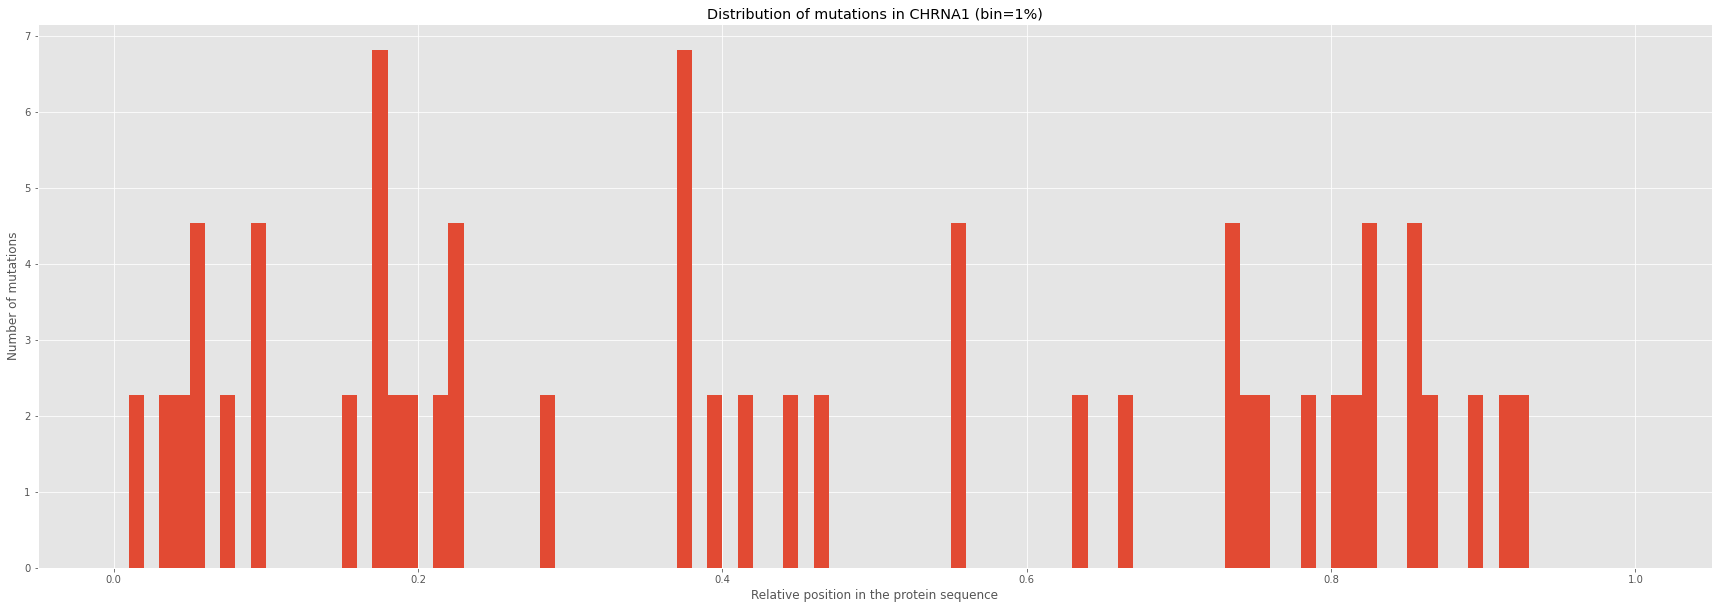

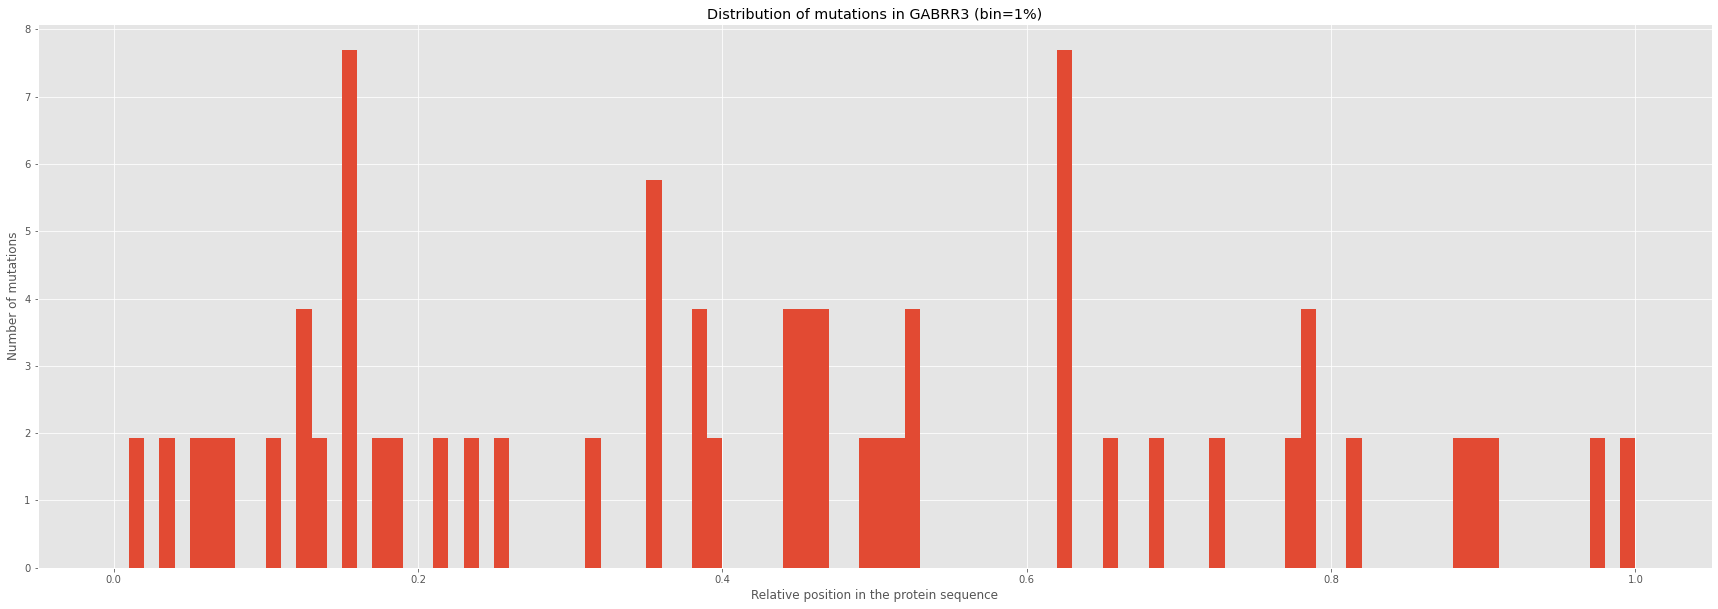

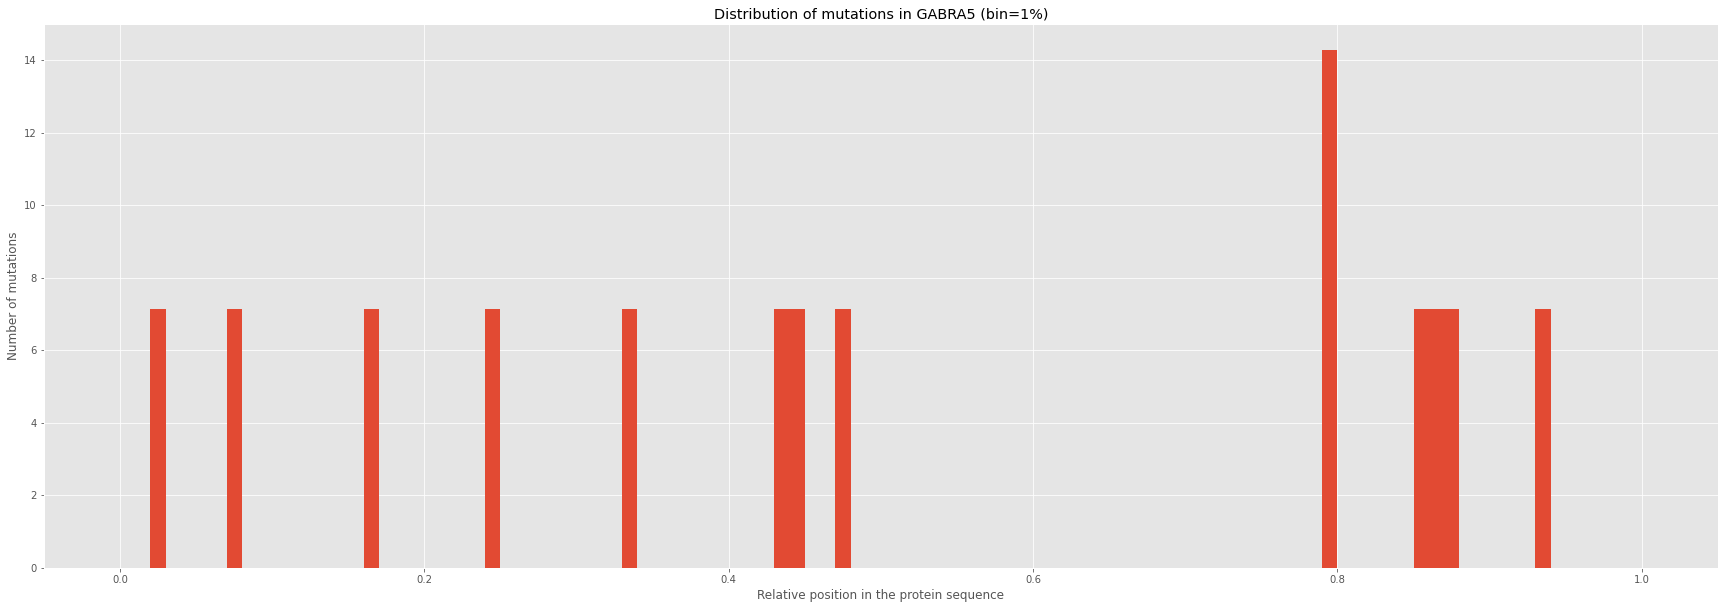

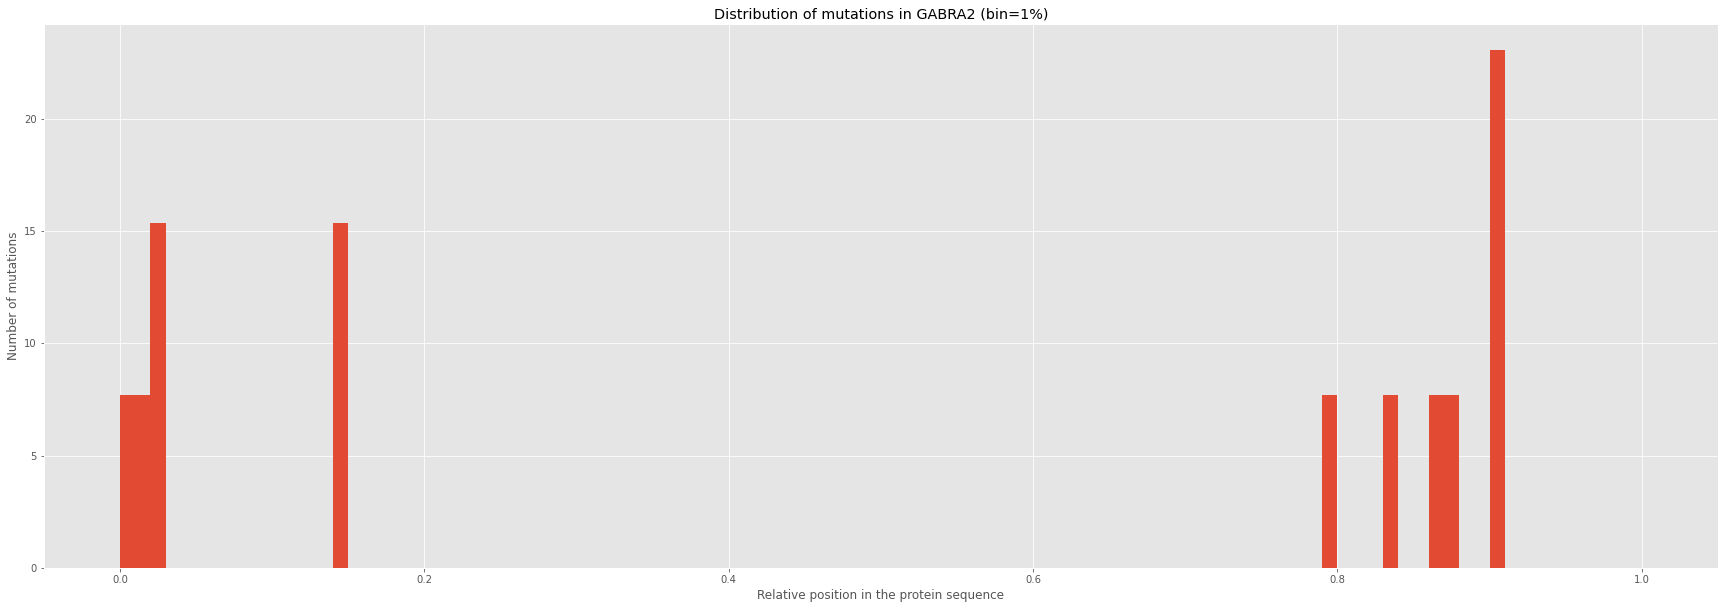

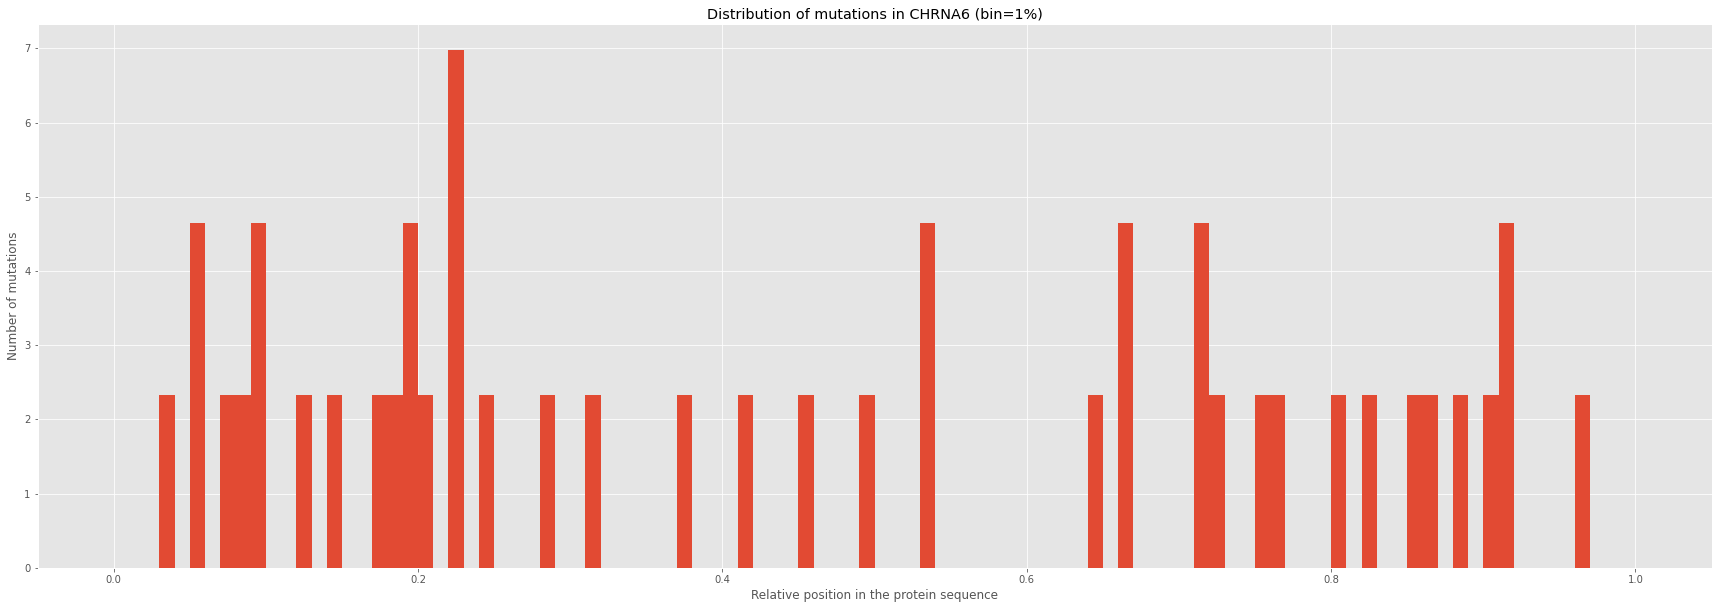

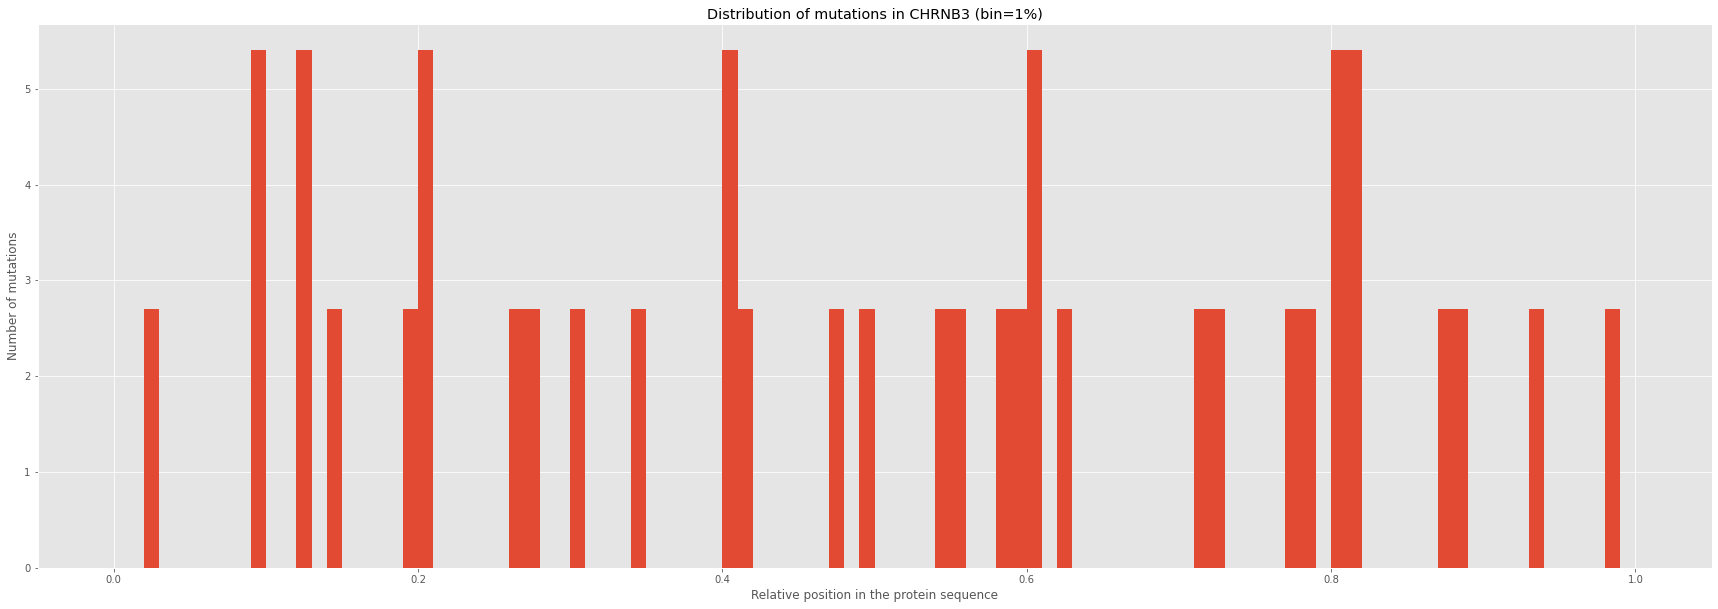

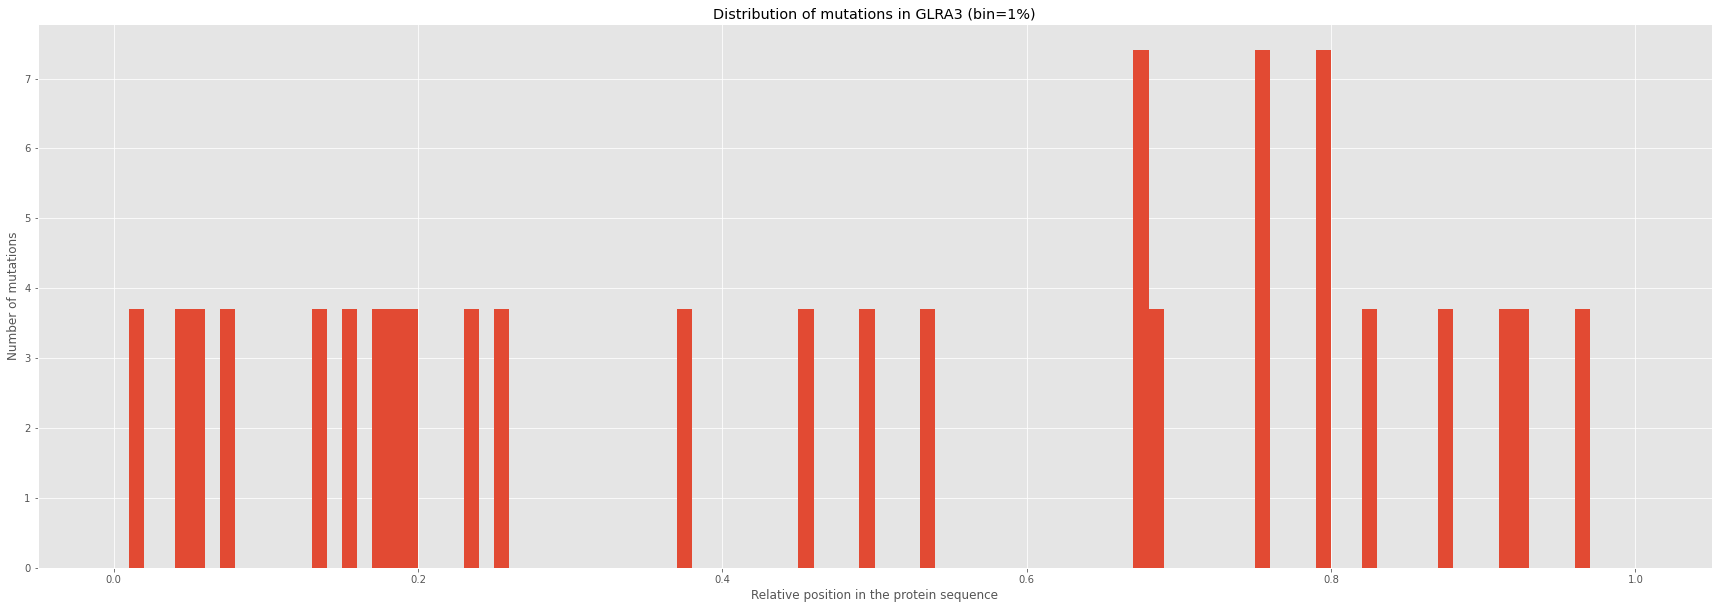

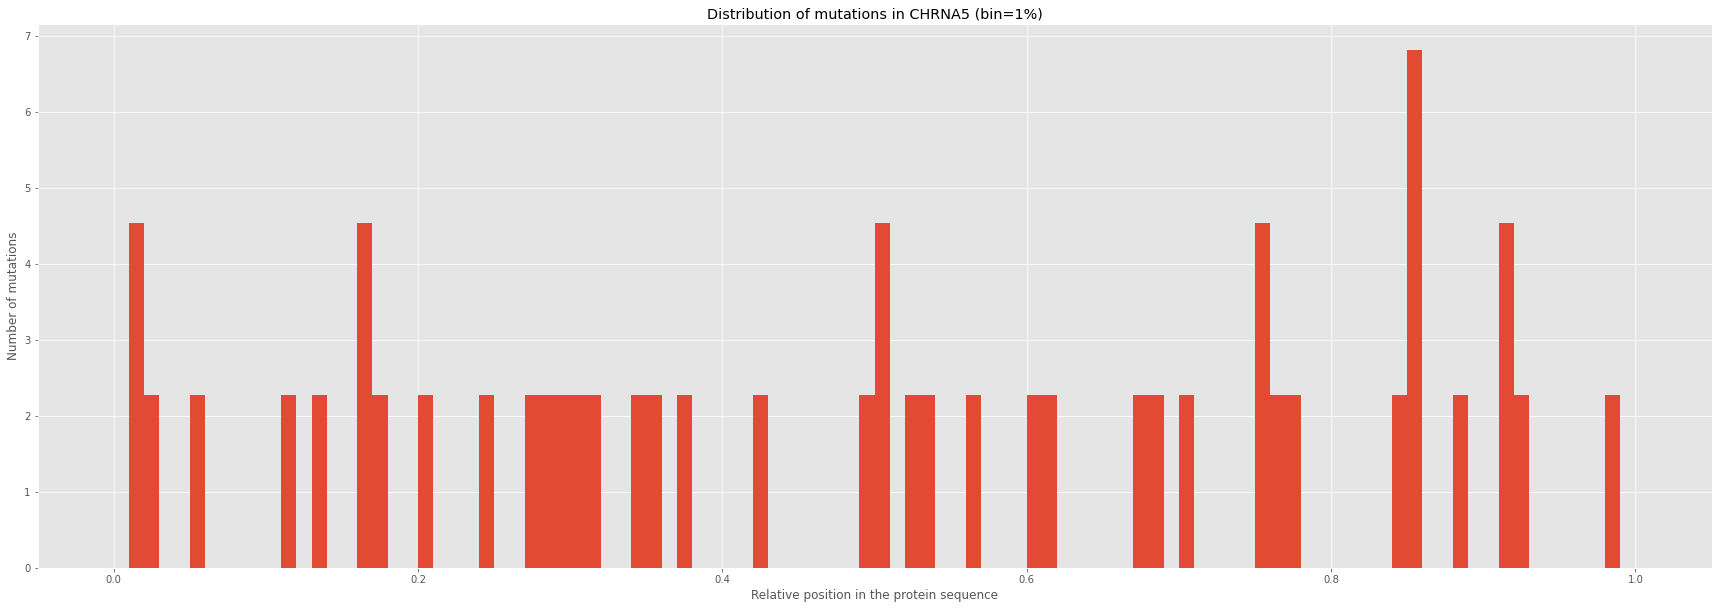

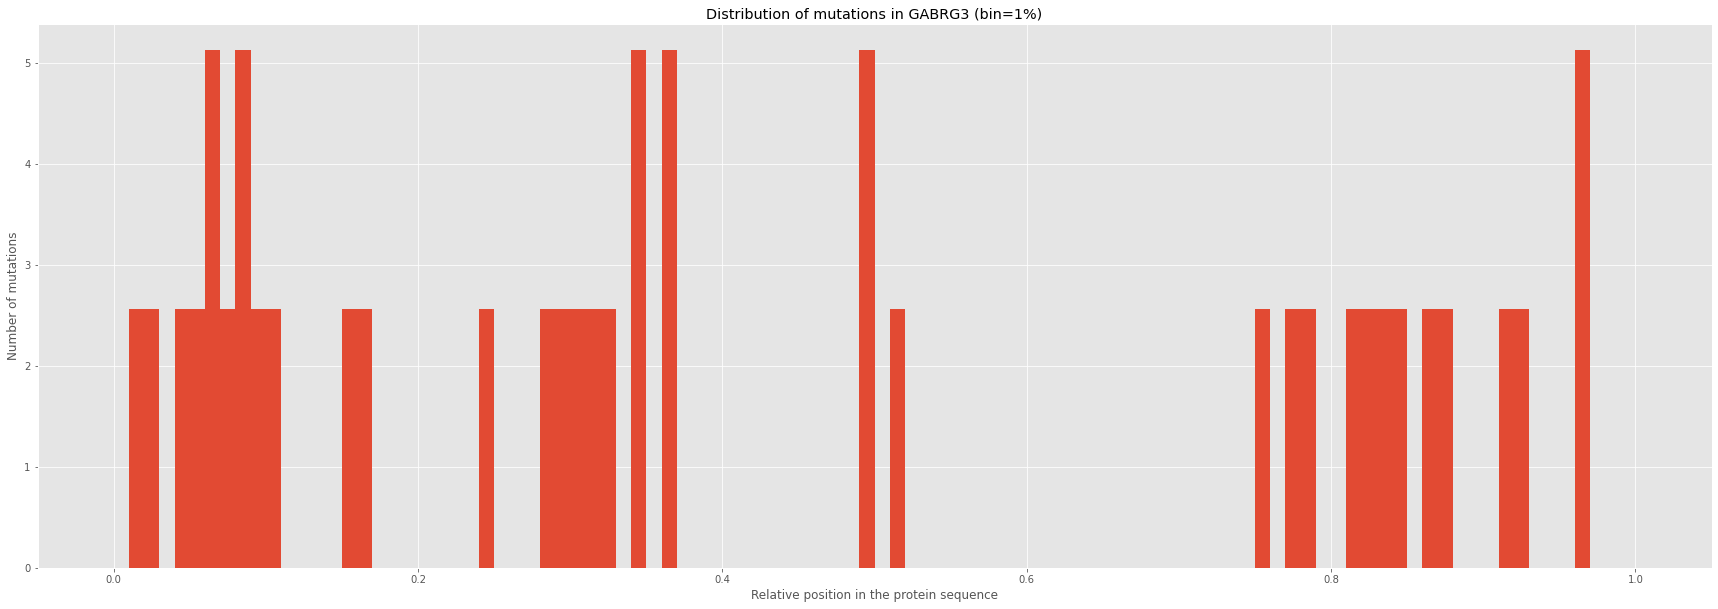

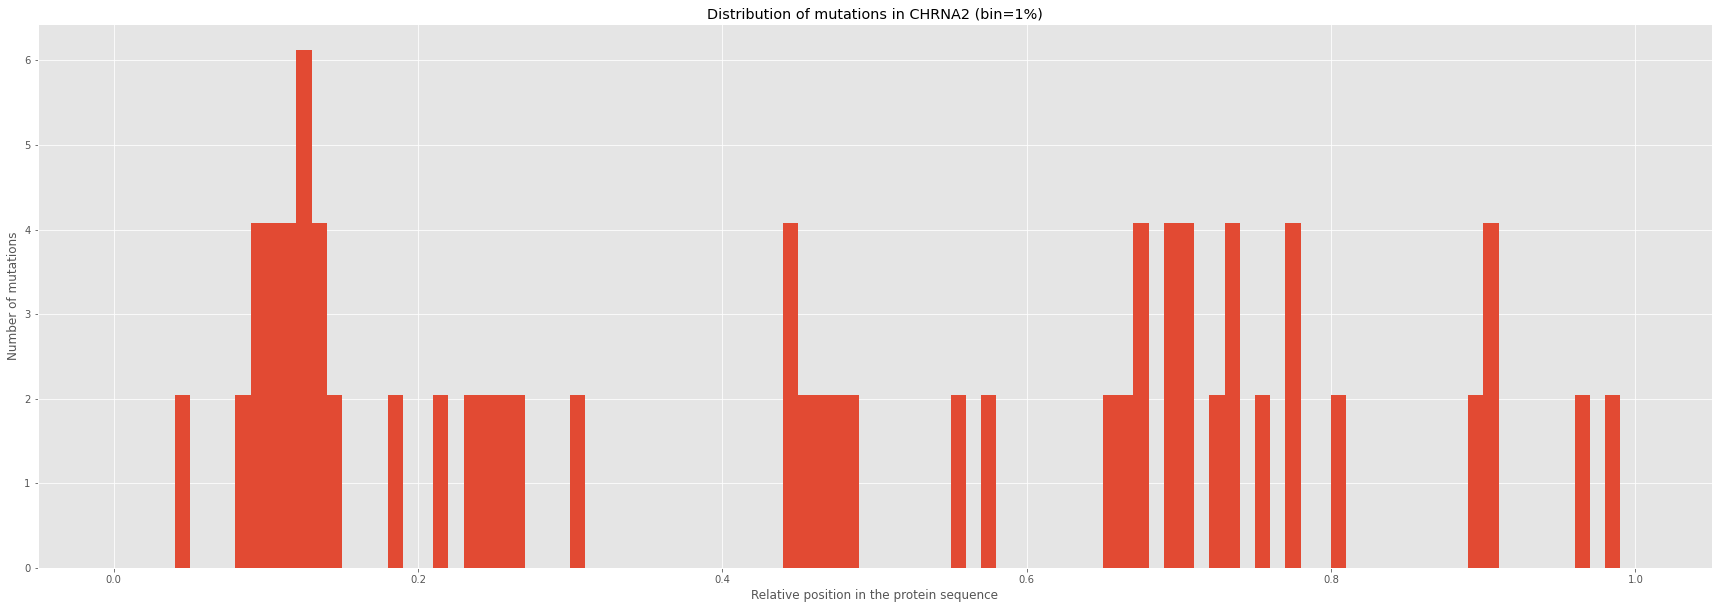

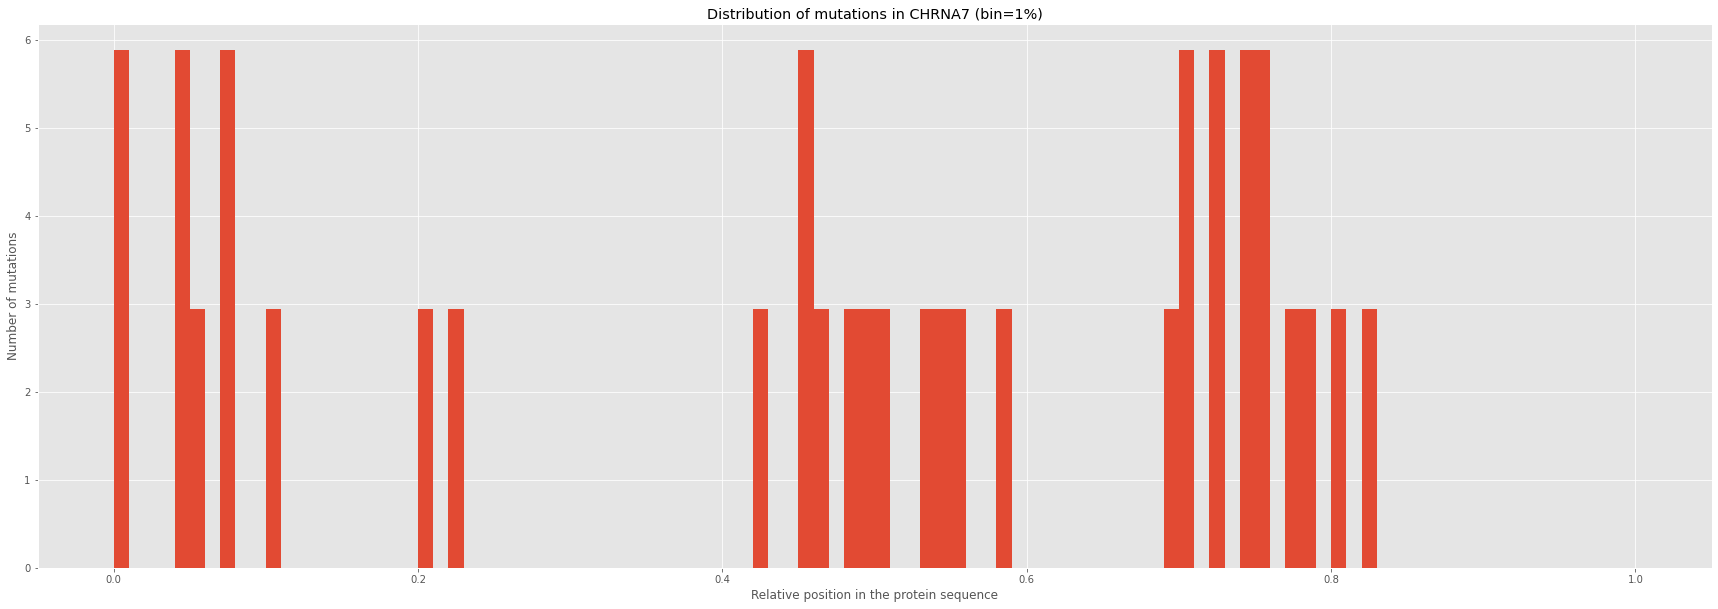

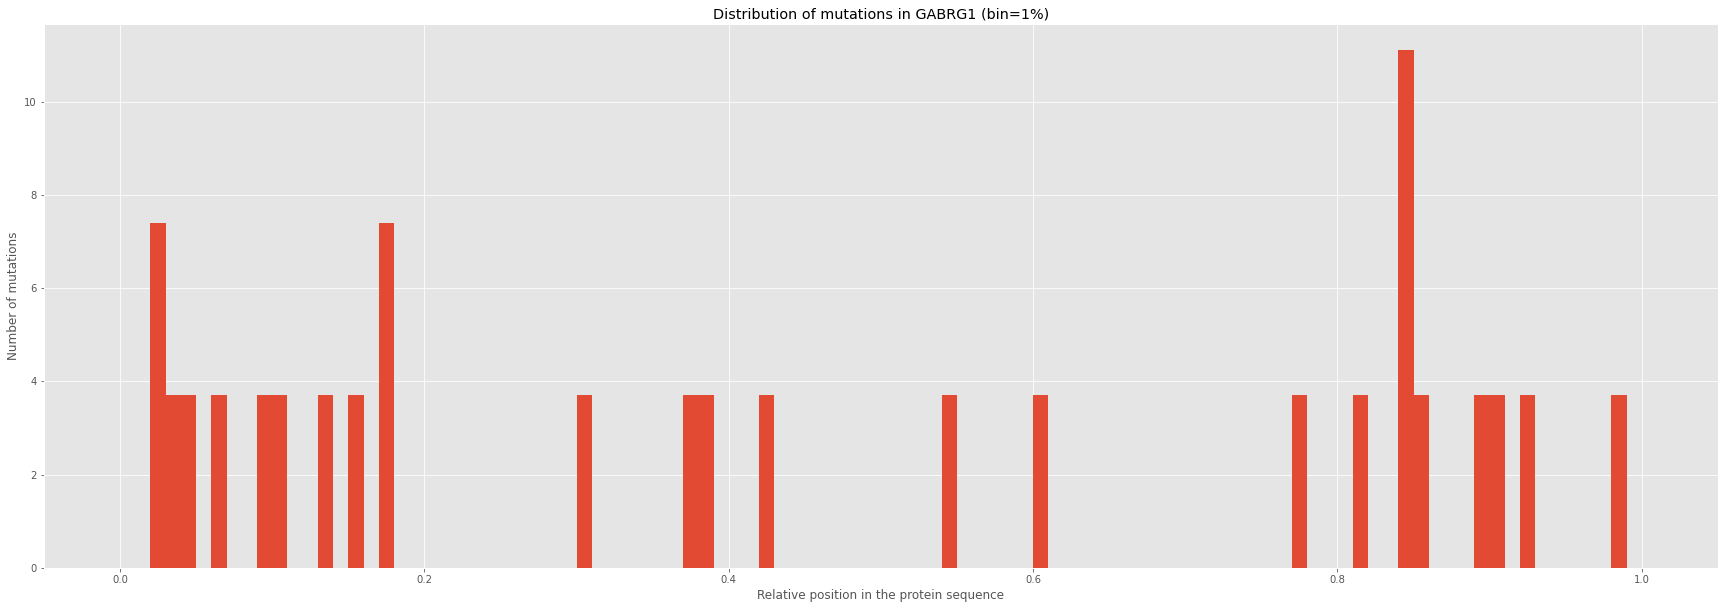

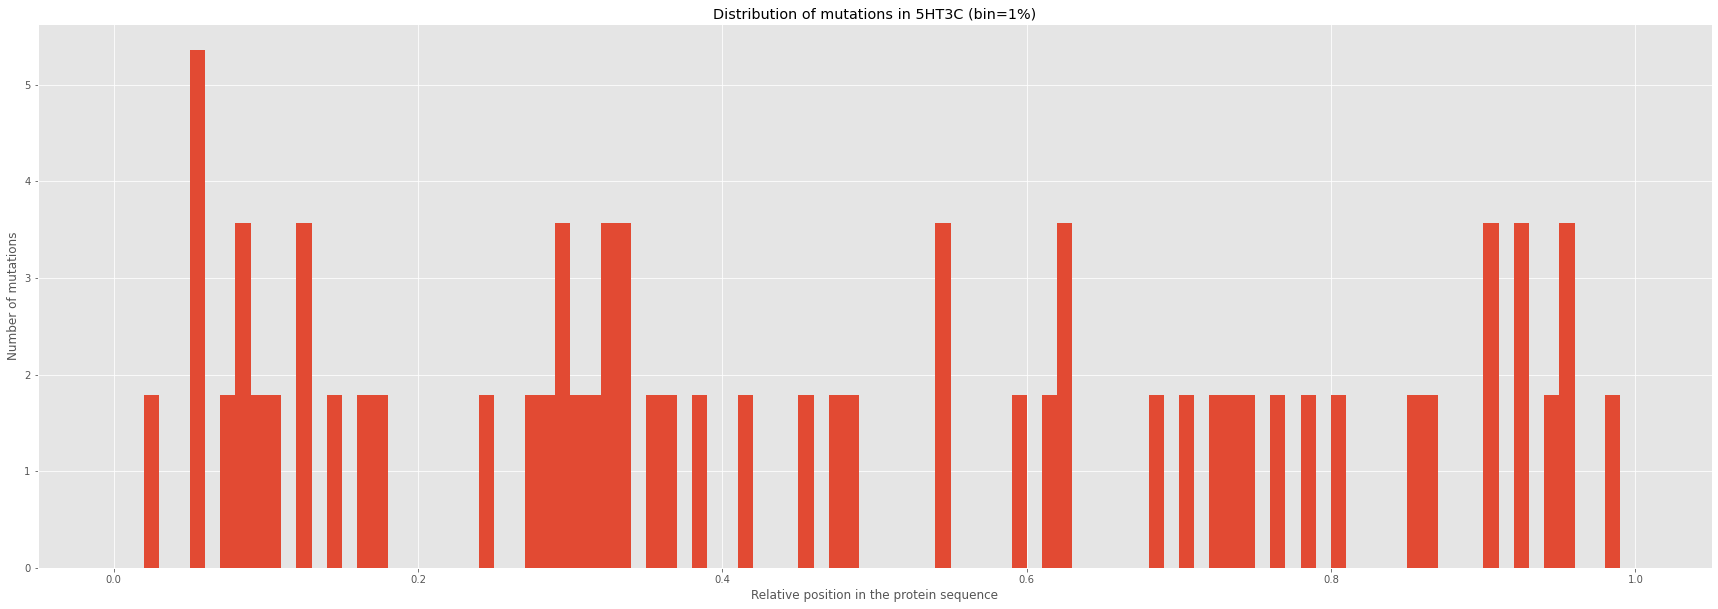

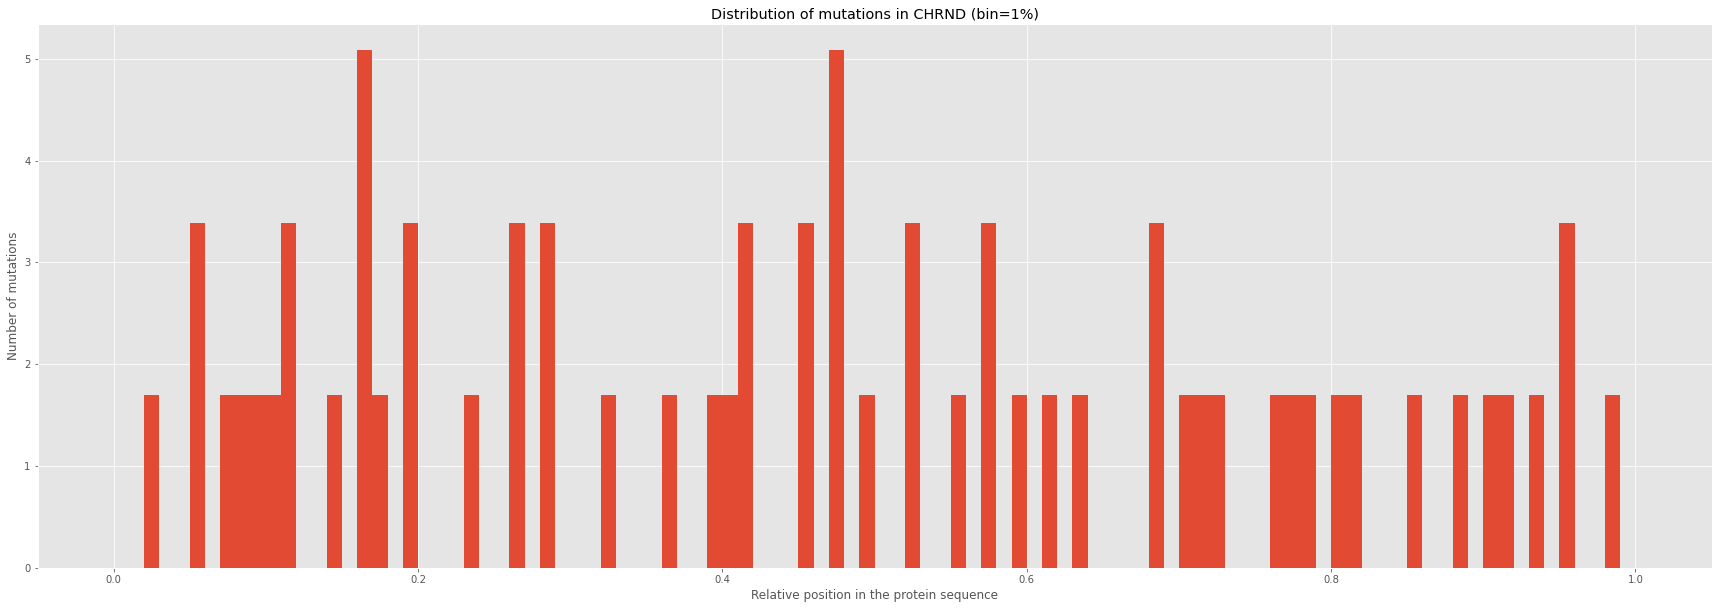

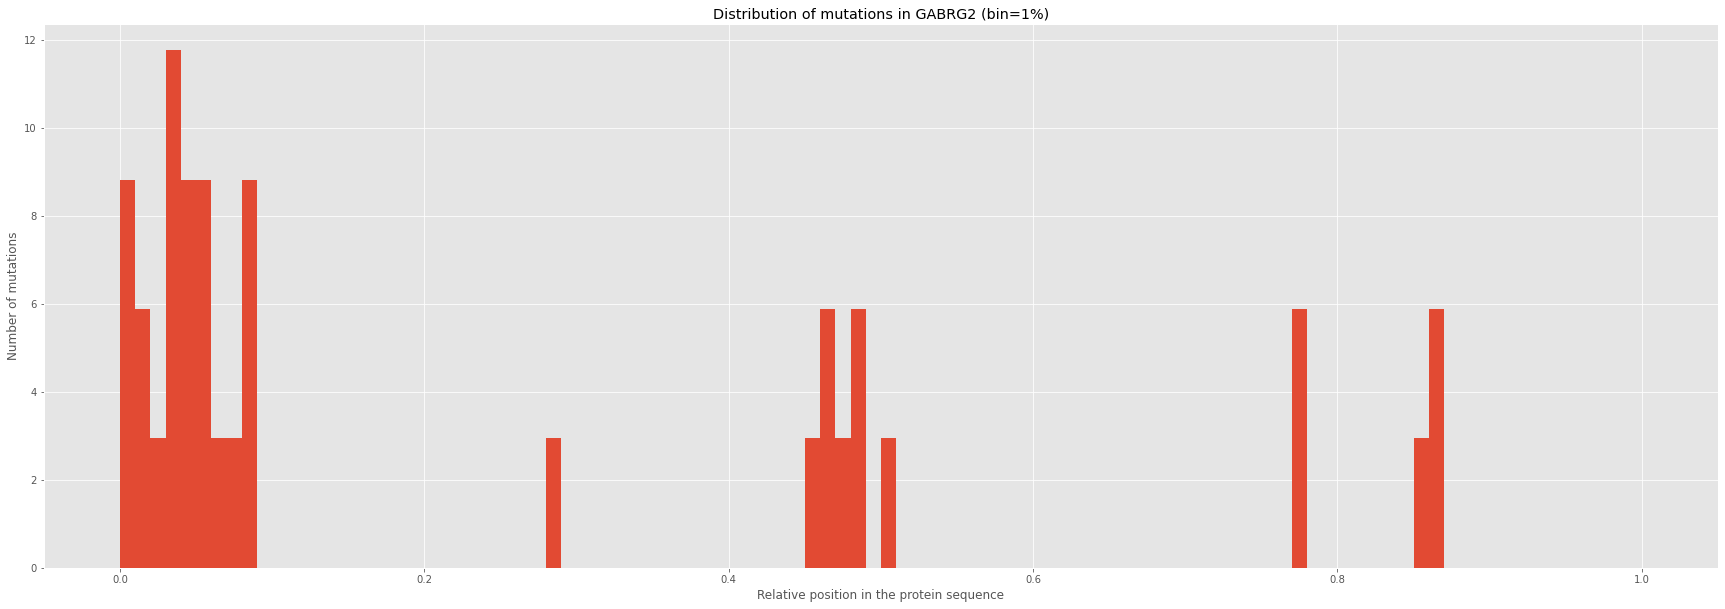

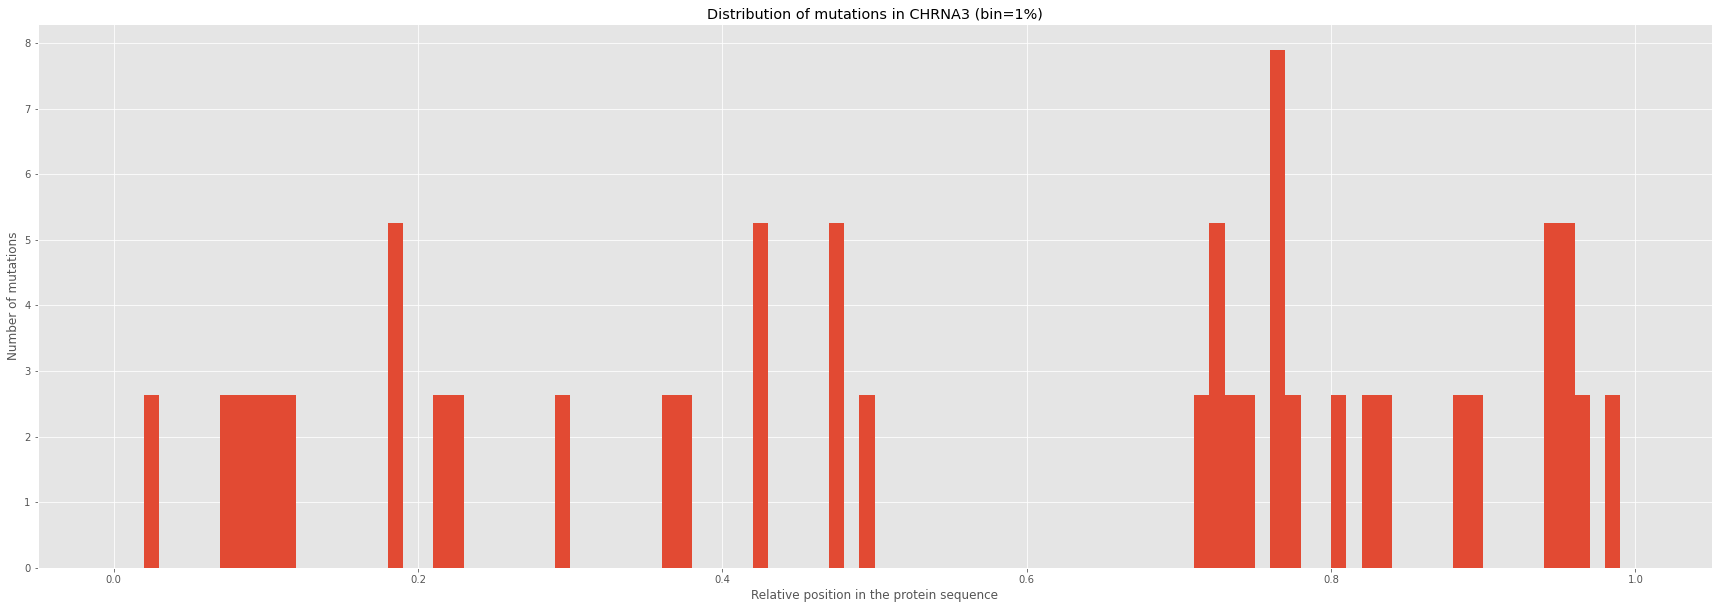

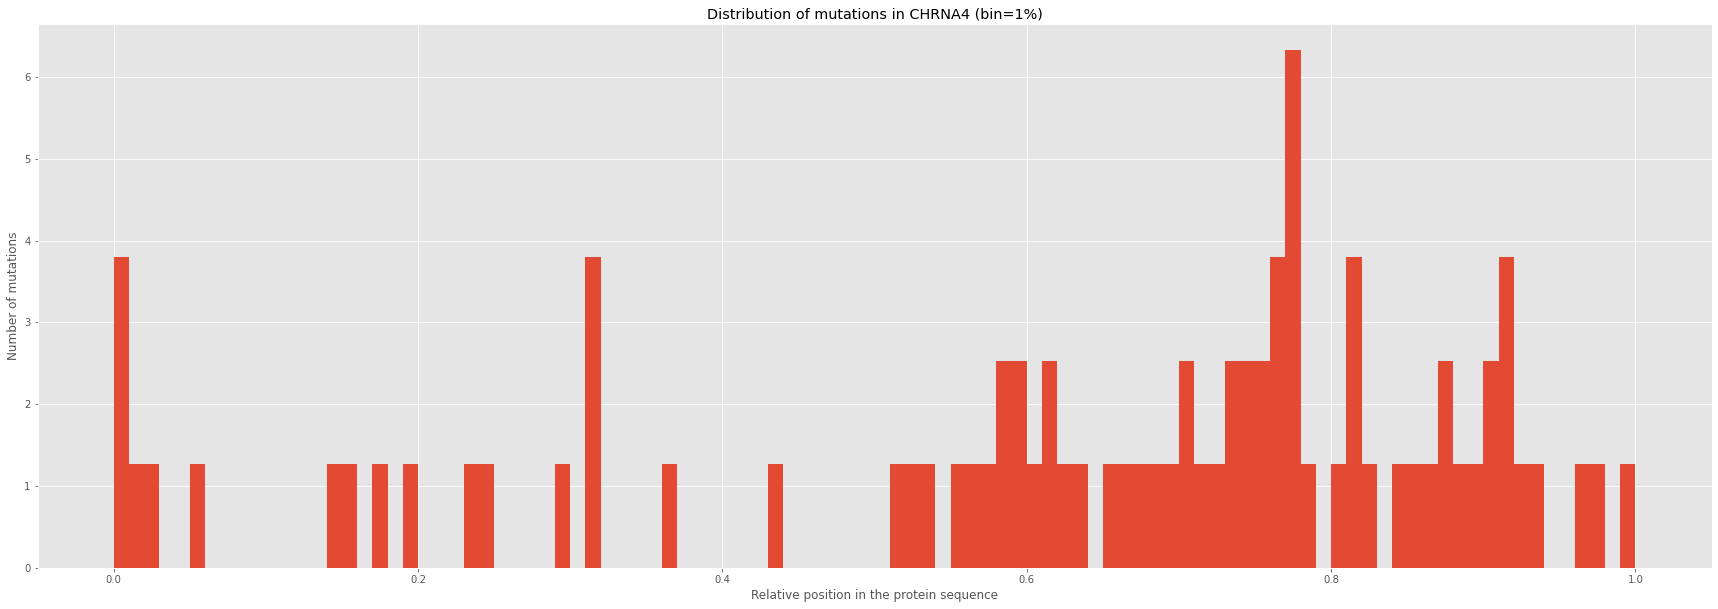

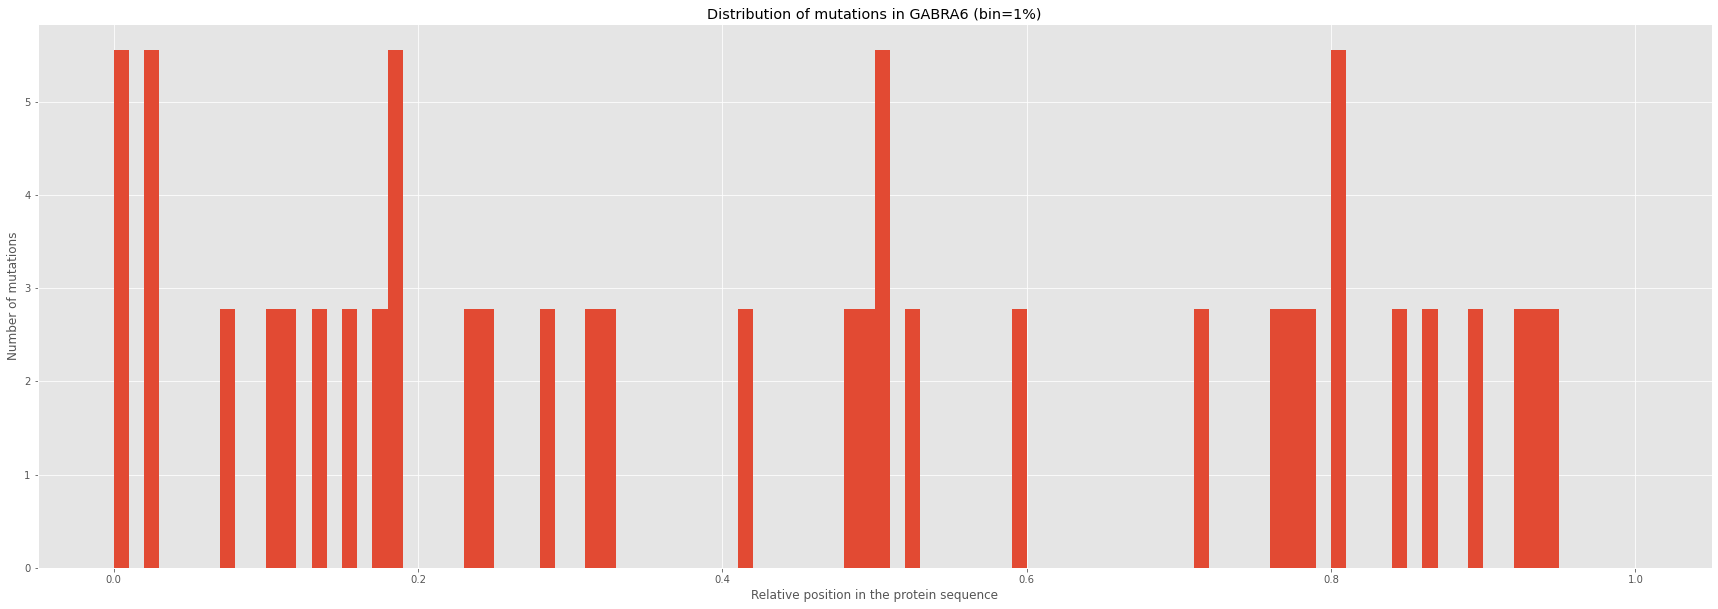

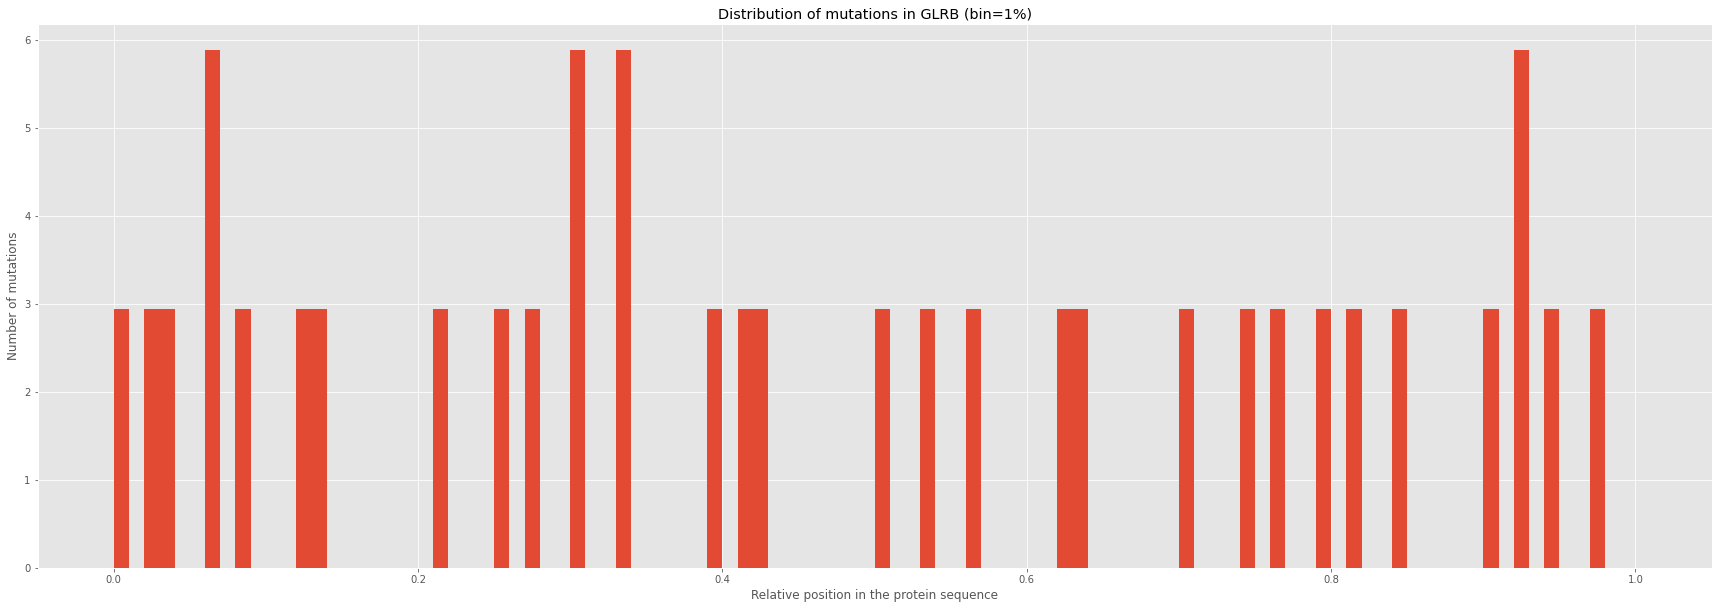

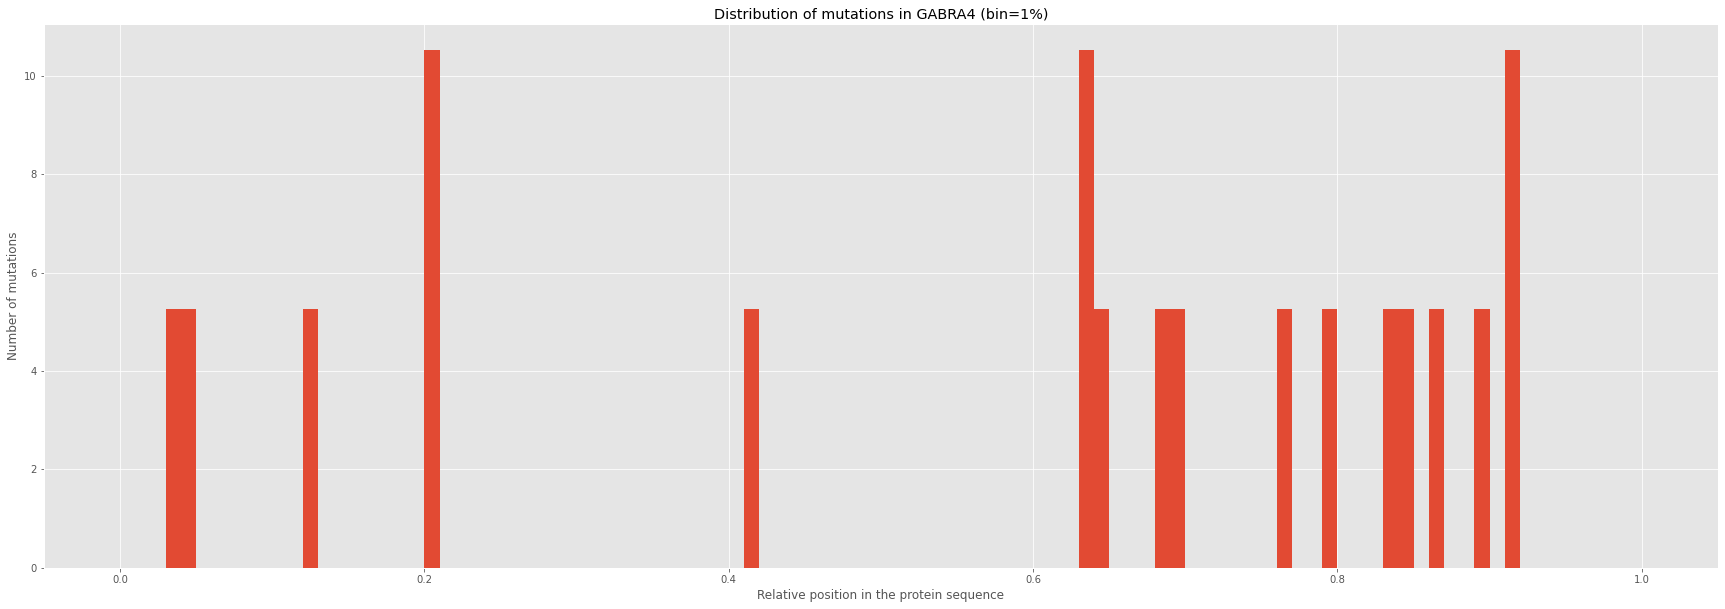

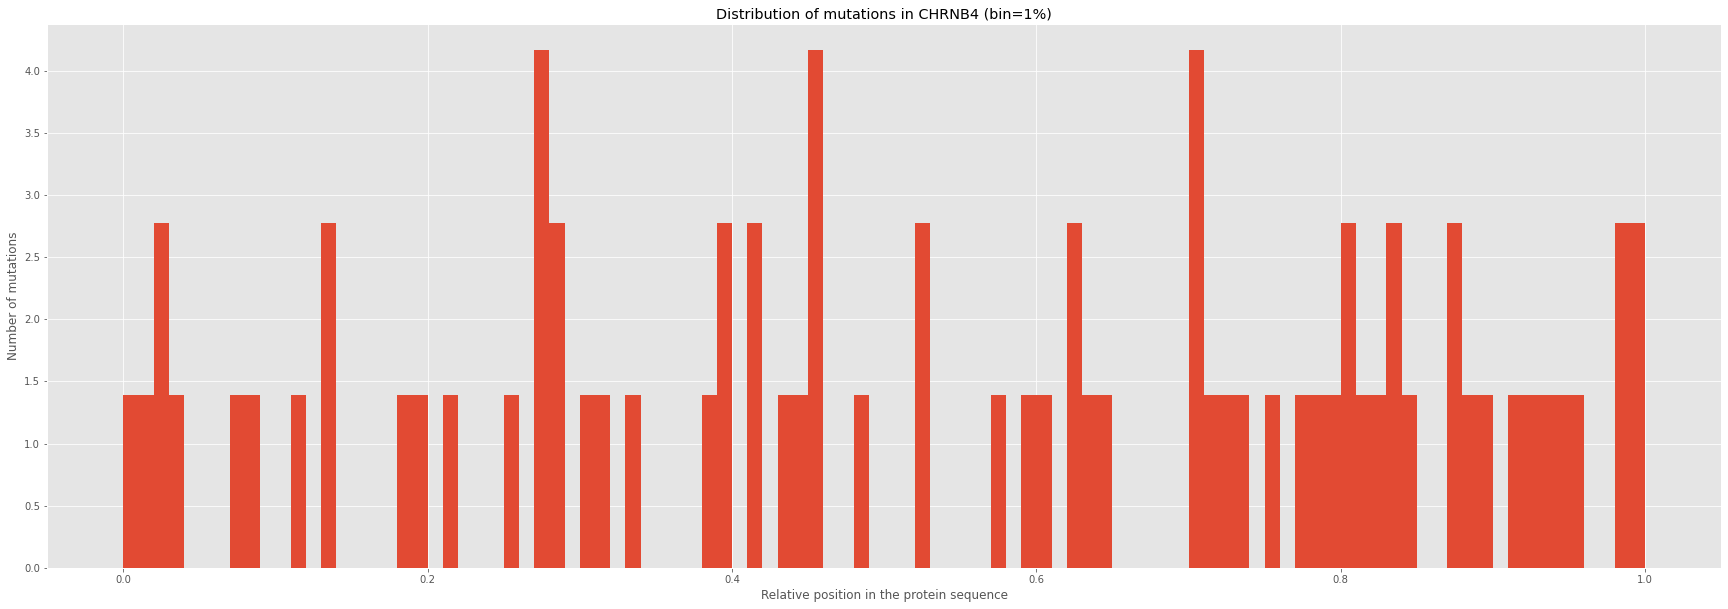

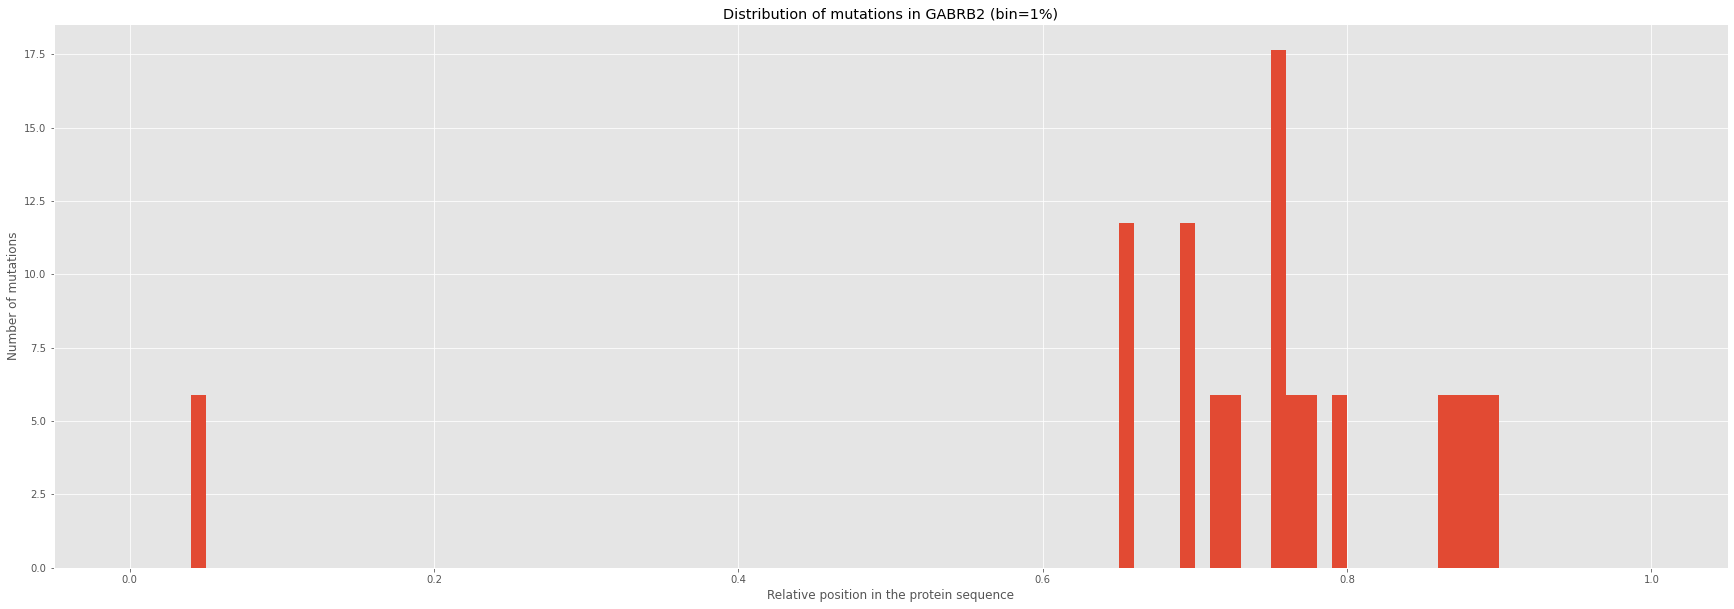

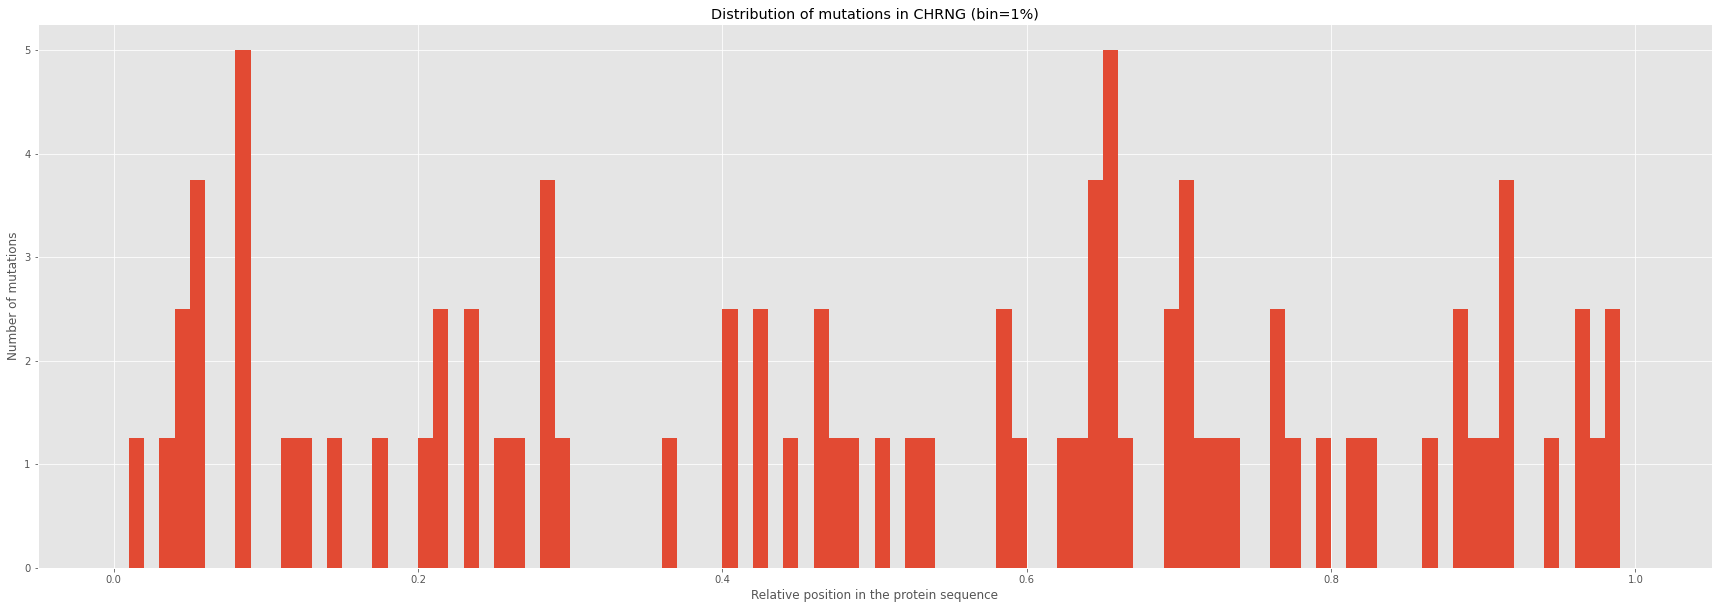

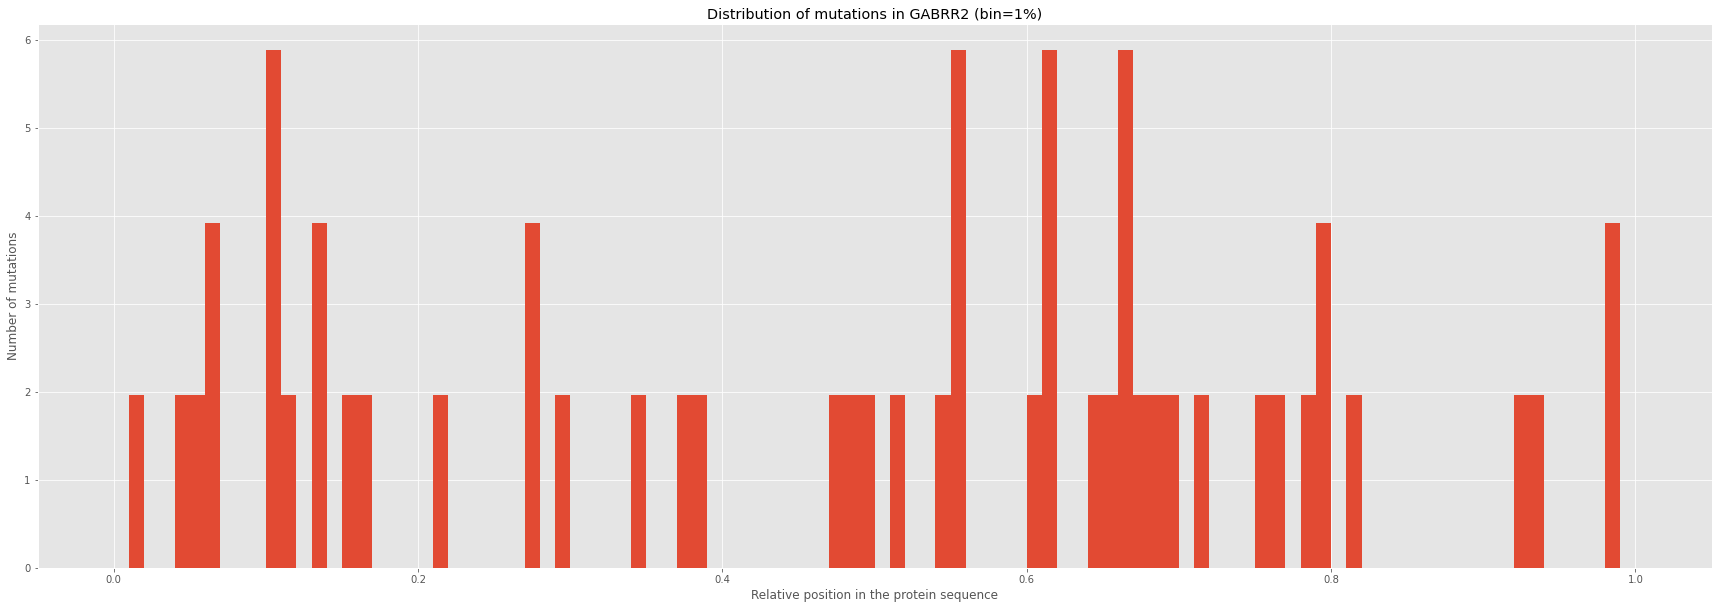

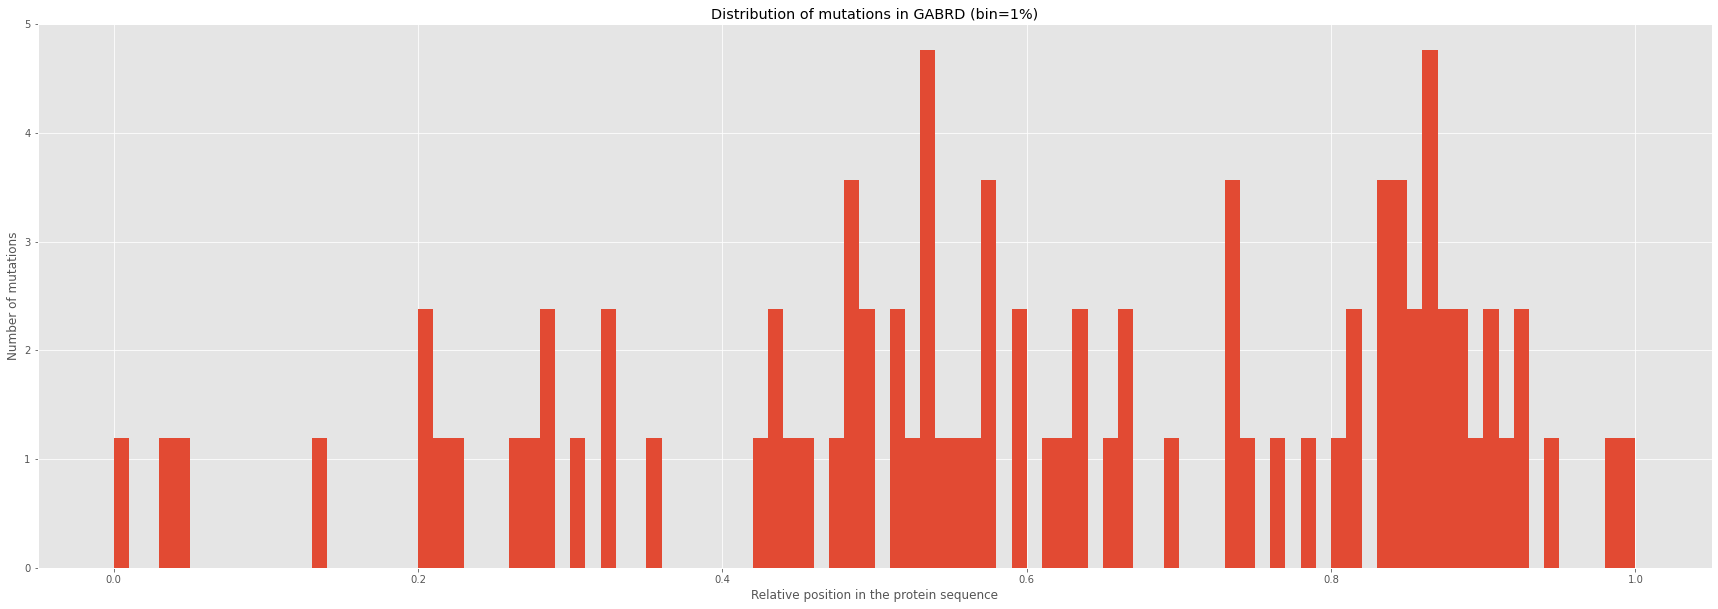

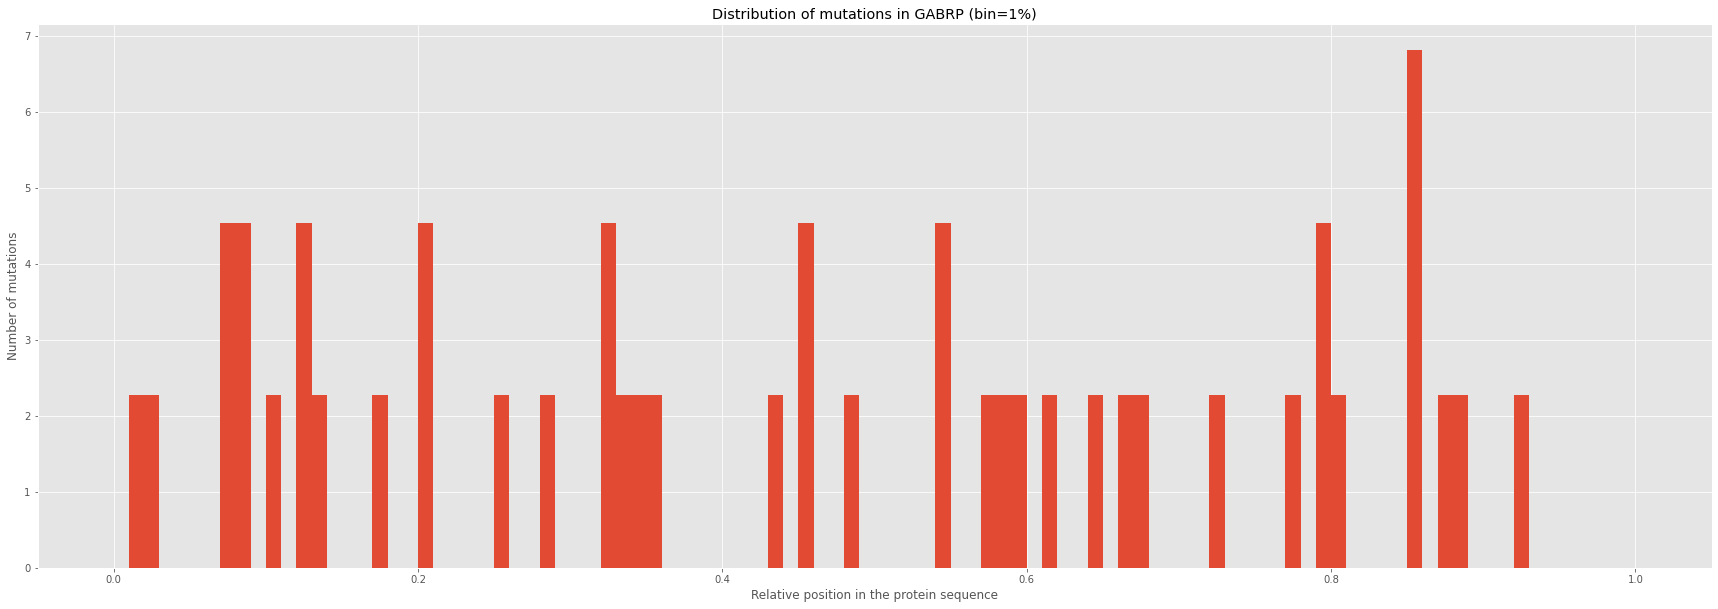

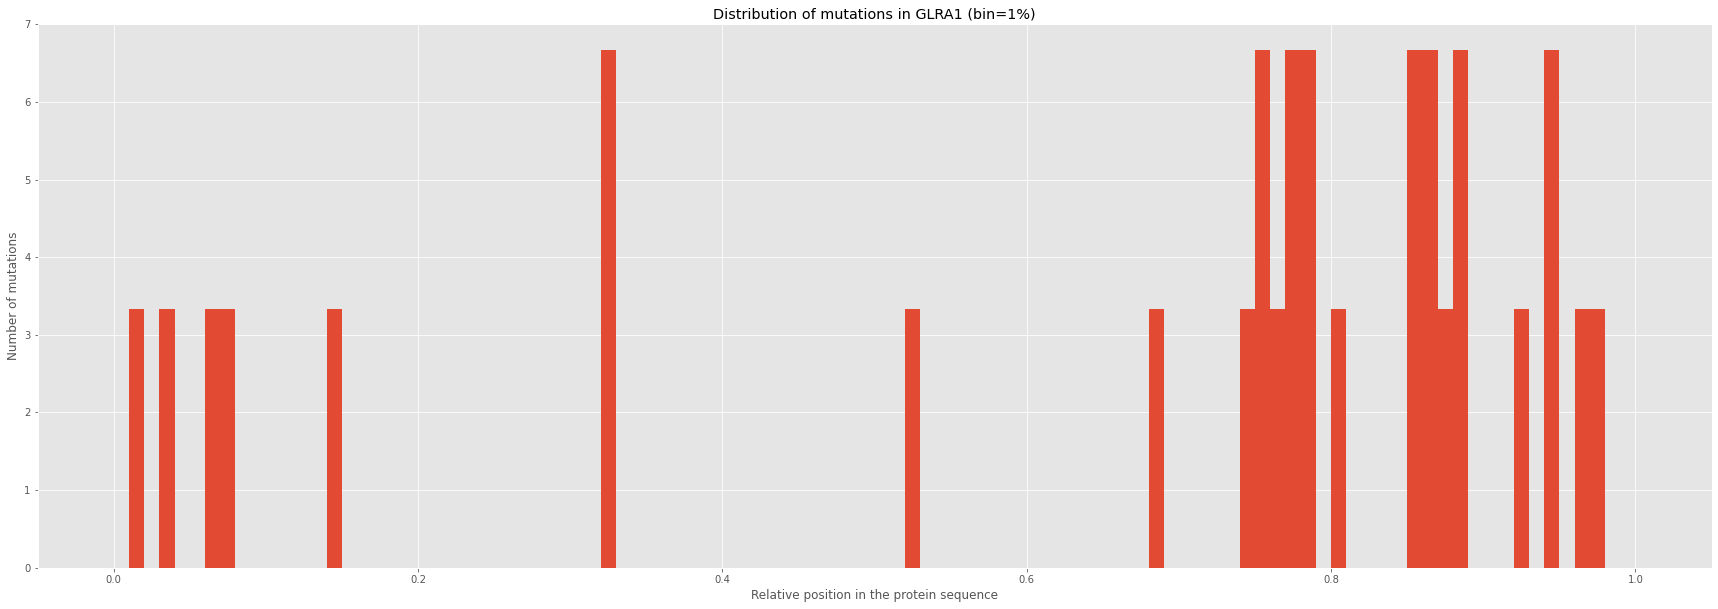

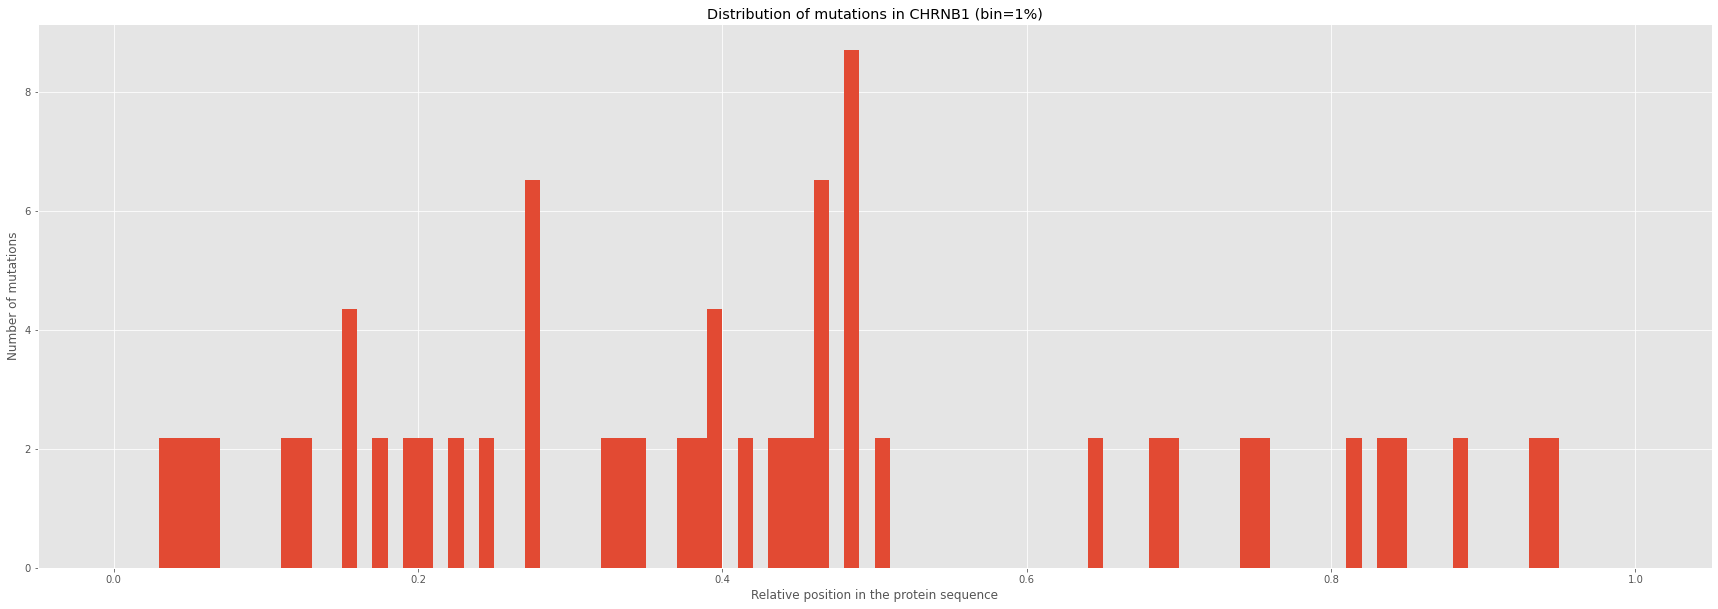

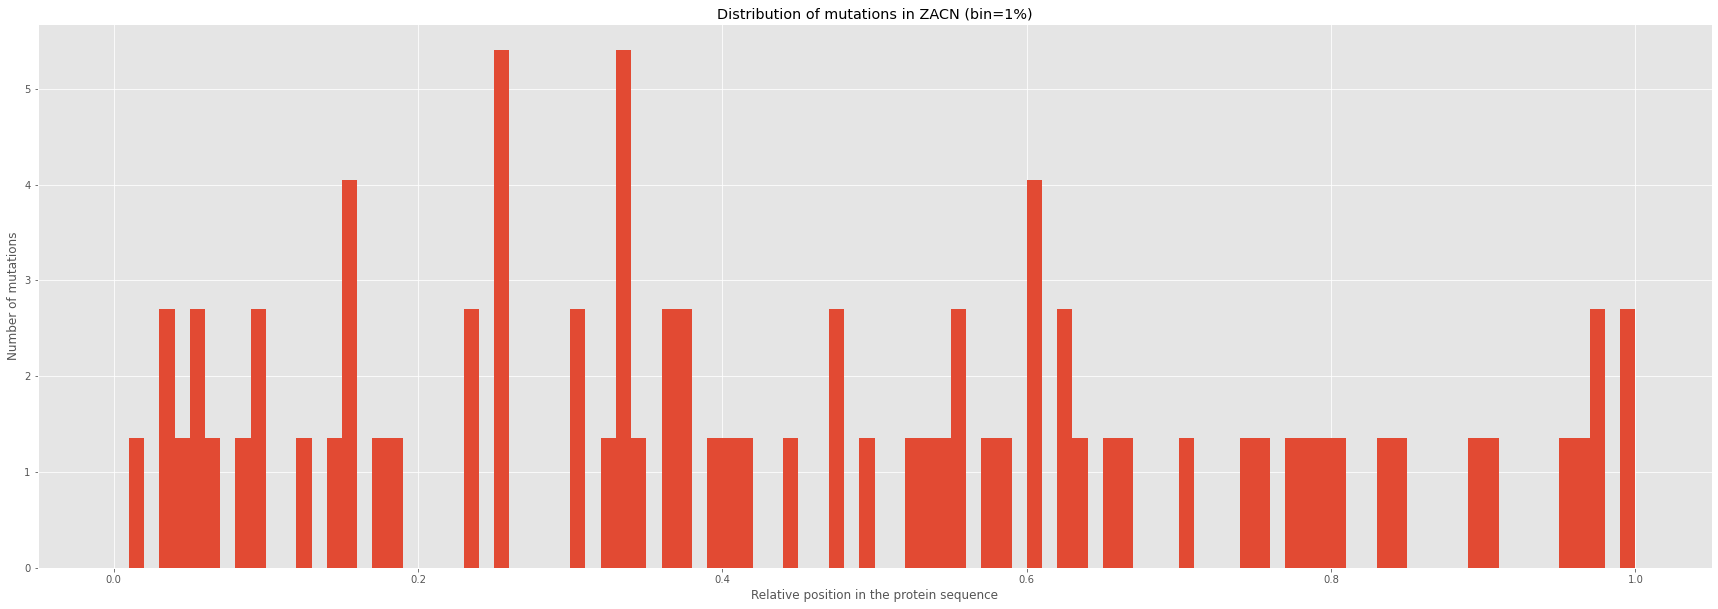

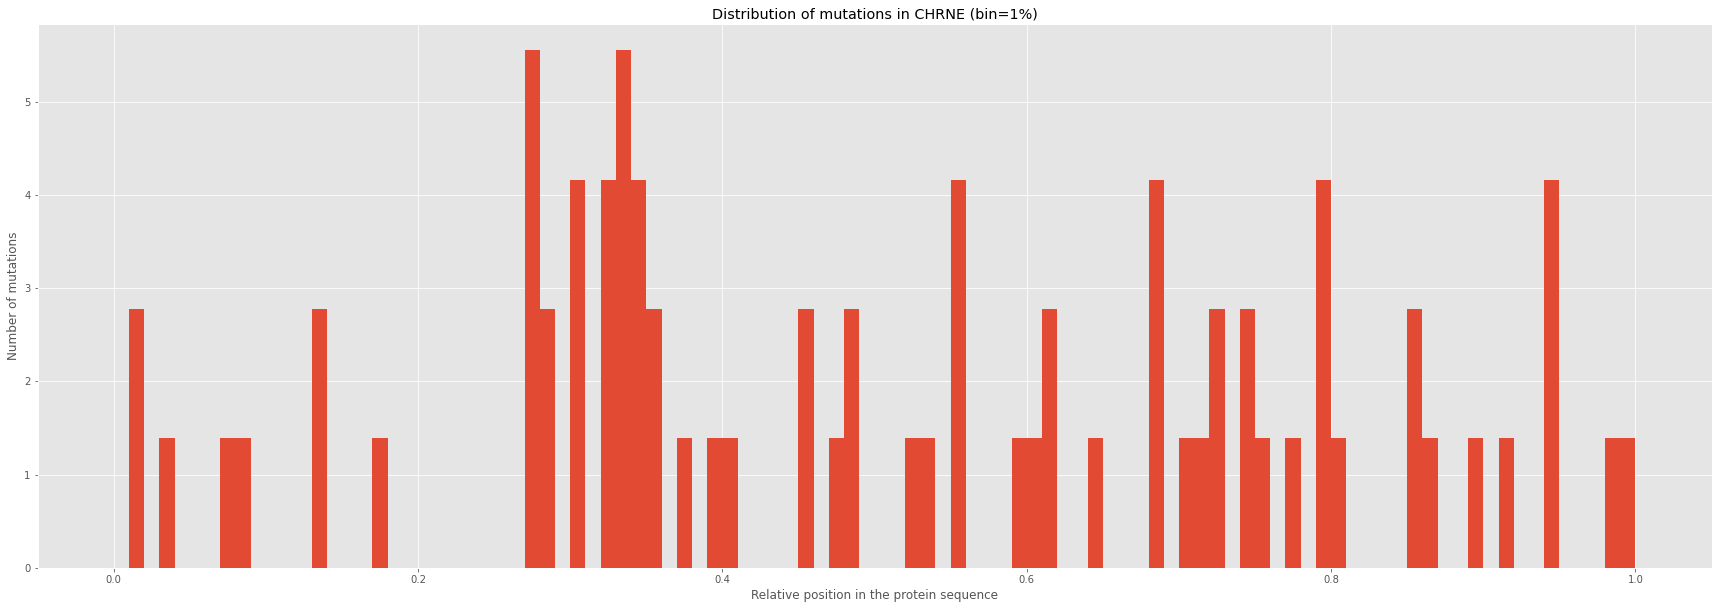

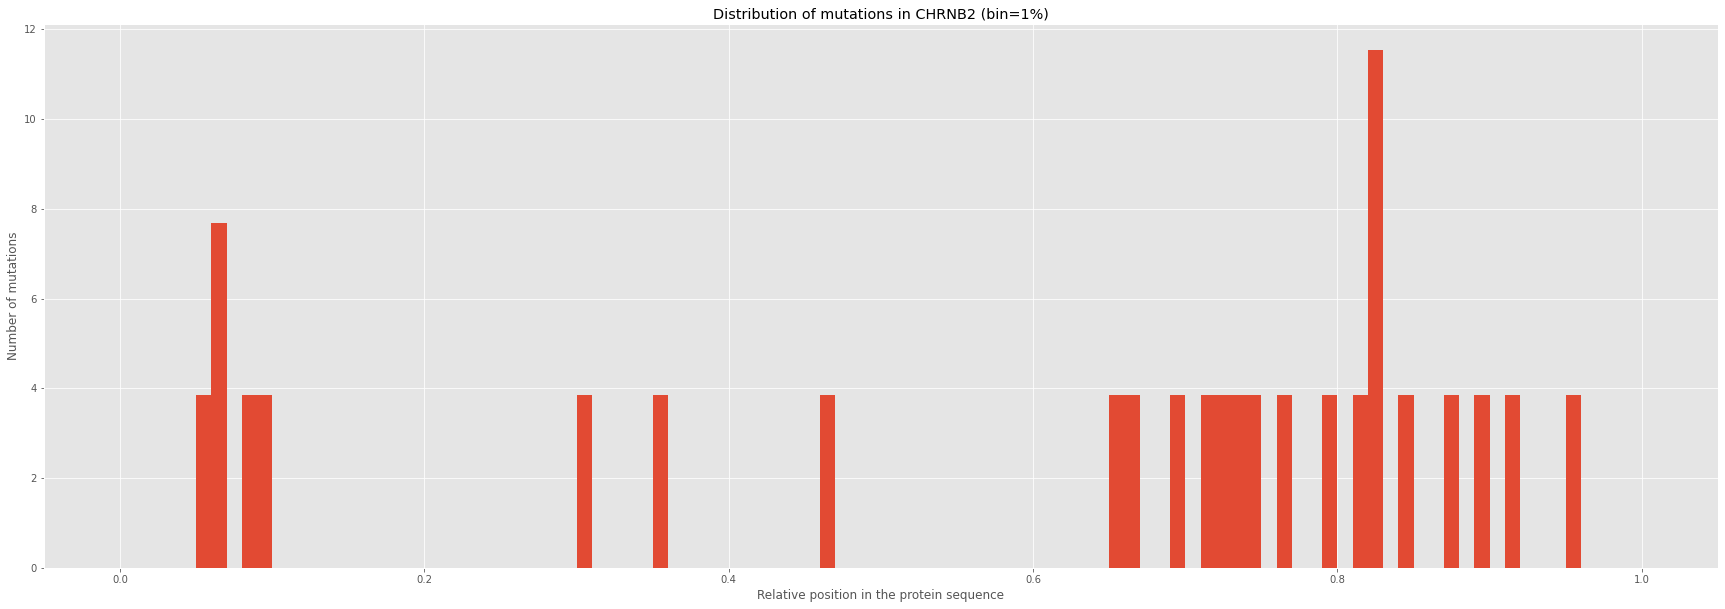

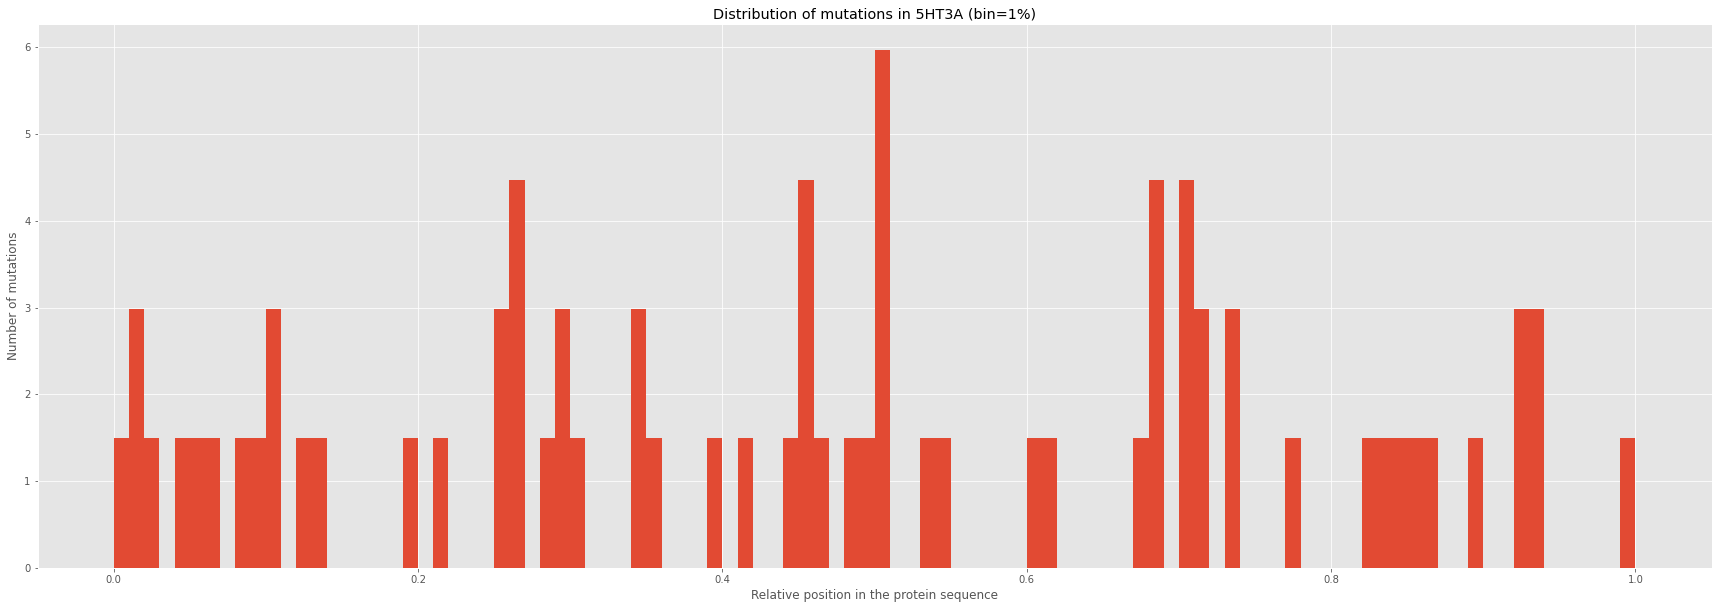

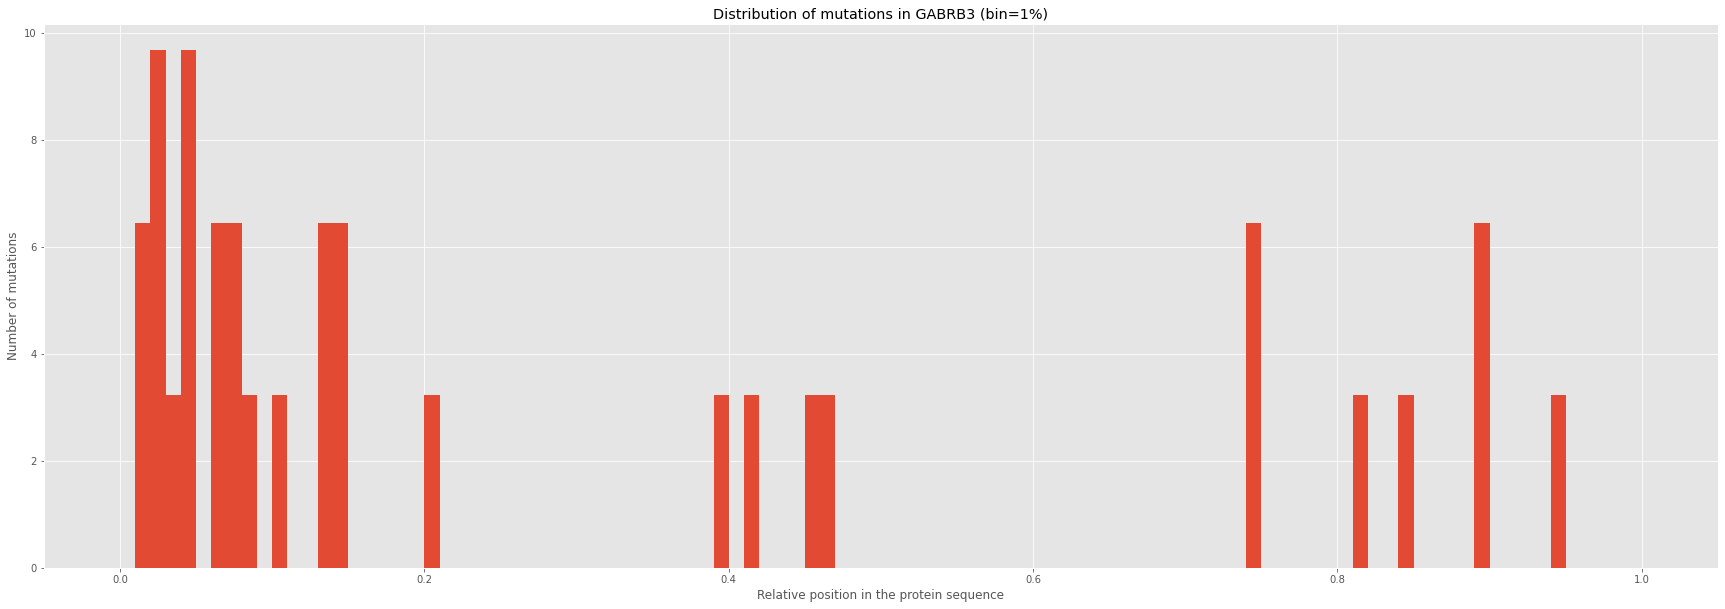

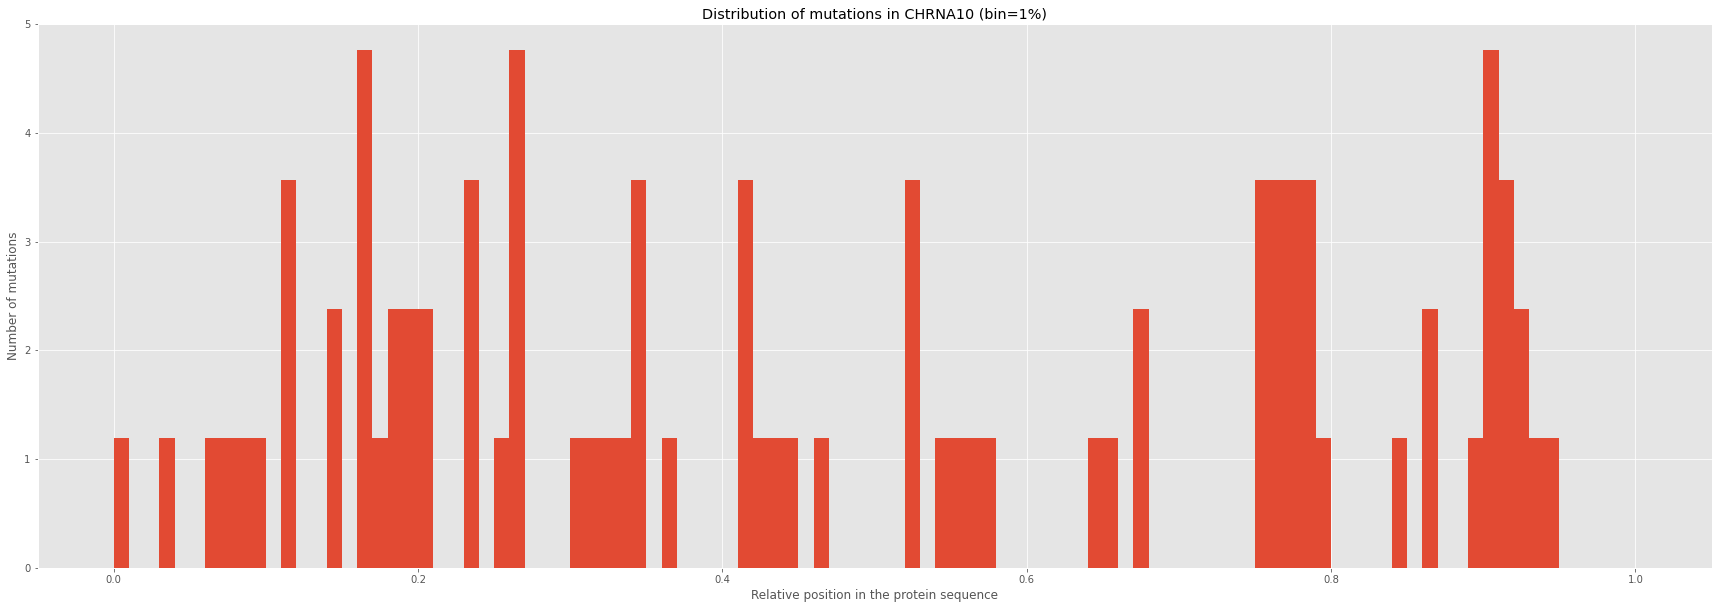

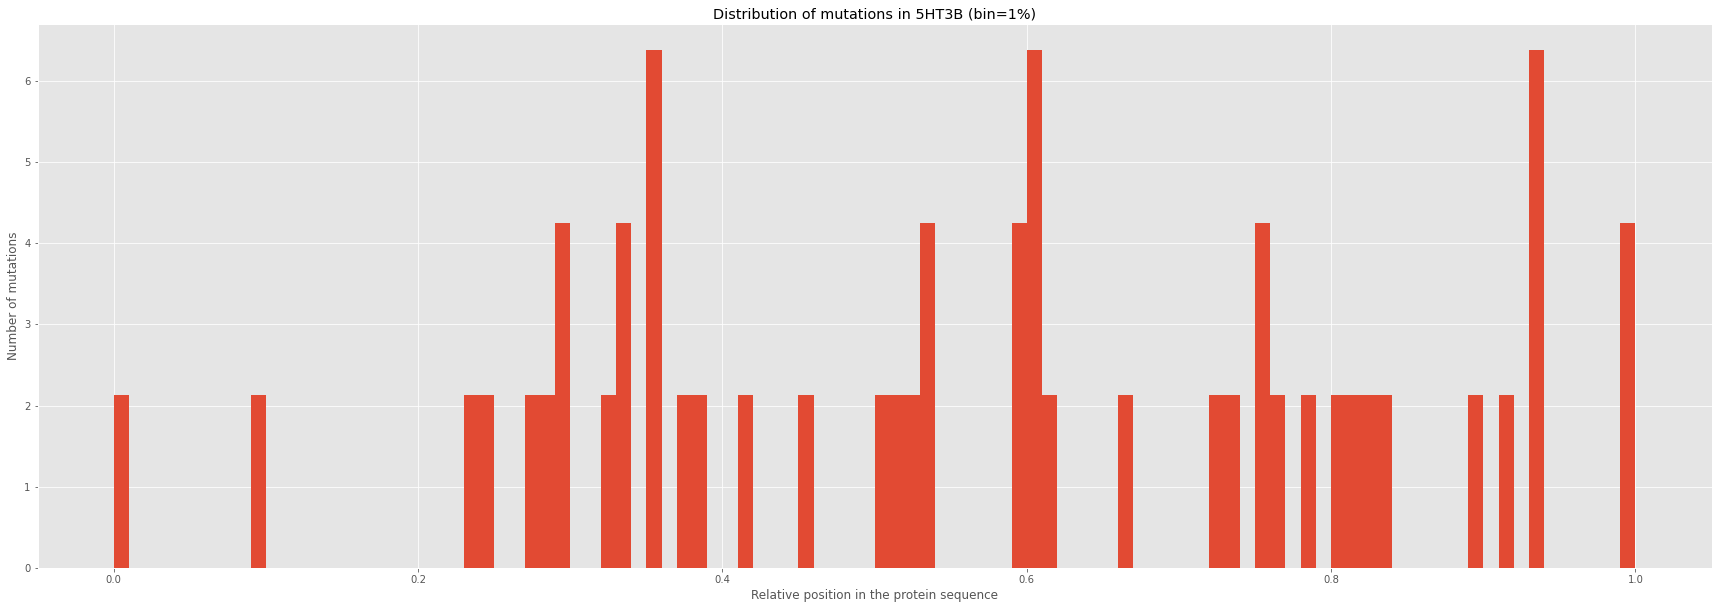

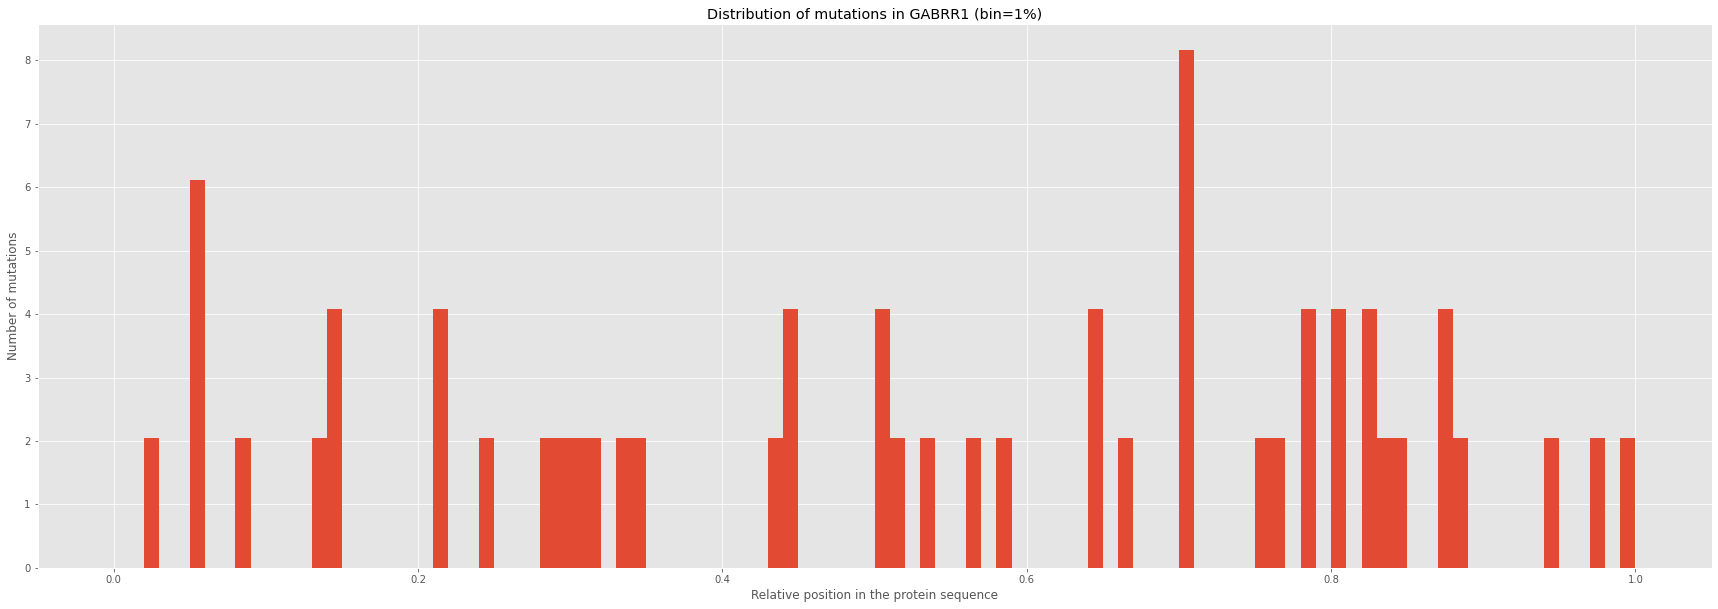

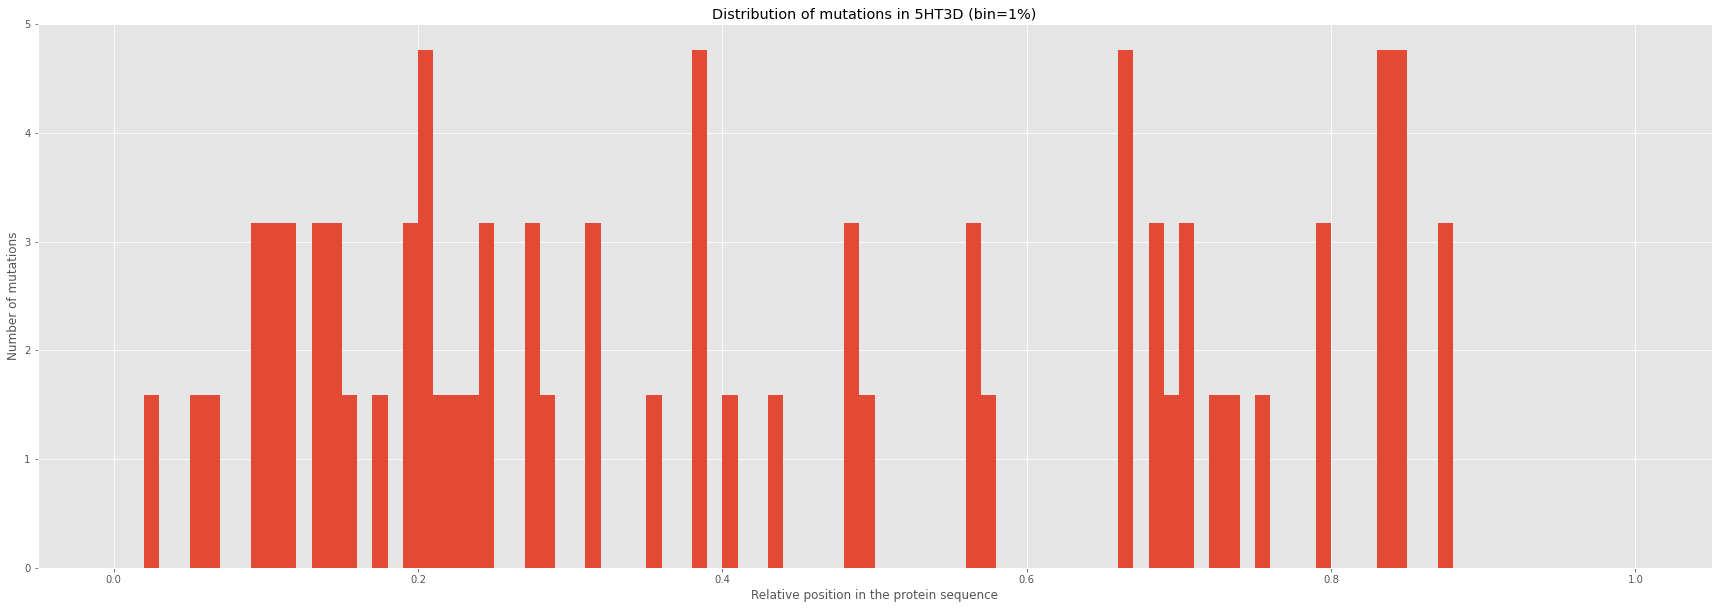

In [73]:
for gene in missense["Gene"].unique():
    pyplot.hist(missense["AA Relative"][missense["Gene"] == gene], bins=[x*0.01 for x in range(0, 101)], density=True)
    pyplot.xlabel("Relative position in the protein sequence")
    pyplot.ylabel("Number of mutations")
    pyplot.title(f"Distribution of mutations in {gene} (bin=1%)")
    pyplot.show()

## Mapping to a common alignment

### Producing the alignment
The alignment was produced through predicted structures by AlphaFold. The sequences used in the prediction are human reference sequences from UniProt, so the predicted structures should be complete. After fetching all the structures, these were imported into MOE session, where they were aligned. First, a global `optimized for superposition` alignment was performed. After that, sequence before the start of the first beta sheet and the domain between M3 and M4 were separately aligned with `sequence only alignment` option. These parts of structures are highly mobile, but are also less important for the comparison. As such, a sequence-based alignment is good enough.

Afterwards extra sequences were added for the proteins which had an unmappable mutations. This was necessary as the reference sequence for a lot of mutations is not the main sequence on UniProt. 

### Using the alignment

In [32]:
alignment = AlignIO.read("Alignment.aln", "clustal")

In [33]:
print(alignment)

Alignment with 133 rows and 1014 columns
--------------------------------------------...--- GABRA1
------------------------------MVQVSIASN-----...--- GABRA1_02
--------------------------------------------...--- GABRA1_03
------------------------------MVQVSIASNEVSYP...--- GABRA1_04
--------------------------------------------...--- GABRA1_05
--------------------------------------------...--- GABRA2
--------------------------------------------...--- GABRA2_02
--------------------------------------------...--- GABRA2_03
--------------------------------------------...--- GABRA2_04
--------------------------MIITQTSHCYMTSLGILF...--- GABRA3
--------------------------------------------...--- GABRA4
--------------------------------------------...--- GABRA5
--------------------------------------------...--- GABRA6
--------------------------------------------...--- GABRA6_02
--------------------------------------------...--- GABRA6_03
--------------------------------------------...--- GABRA6_04
-

We create a class to encapsulate the alignment and pack in it all the functions we would need for interacting with it.

In [34]:
class Alignment:
    def __init__(self, alignment_file) -> None:
        alignment = AlignIO.read(alignment_file, "clustal")
        self._sequences = {sequence.id: sequence for sequence in alignment}
    
    def convert_to_reference(self, id, acid, number):
        """
        Returns the position in the reference sequence (STARTING FROM 1) if found, else -1.
        The provided number also must start the amino acid count with 1.
        """
        if len(acid) == 3:
            acid = seq1(acid)
        sequence = self._sequences[id]
        i = 0
        for j, residue in enumerate(sequence):
            if residue != "-":
                i = i+1
                if i == number:
                    if residue == acid:
                        return j+1
                    else:
                        return -1

In [35]:
ali_class = Alignment("Alignment.aln")

In [36]:
ali_class.convert_to_reference("GABRA1", "T", 20) # Test; should be 51

71

In [37]:
missense["AA Referenced"] = missense.apply(lambda x: ali_class.convert_to_reference(x["Gene"], x["Protein Consequence"].split(".")[1][0:3], x["AA Number"]), axis=1)

C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


How many of the amino acids we could not map?

In [38]:
print(-sum(missense["AA Referenced"][missense["AA Referenced"] == -1]))
print(-sum(missense["AA Referenced"][missense["AA Referenced"] == -1]) / missense.shape[0])

310.0
0.15752032520325204


For some SNPs the change in reference genome assembly changed the protein change assignment to an incorrect one. We use the GnomeAD v2 assignments in the cases where there is an entry present. Where this also doesn't yield the correct assignment we use the alternative alignments to see if the mutation might have been mapped onto a non-main transcript.

In [39]:
alignment_subunits = ali_class._sequences.keys()
for i in range(0, missense.shape[0]-1):
    if missense.iloc[i]["AA Referenced"] == -1:
        if missense.iloc[i]["rsIDs"] is None:
            x = dataset_alternative[(dataset_alternative["Gene"] == missense.iloc[i]["Gene"]) & (dataset_alternative["Transcript Consequence"] == missense.iloc[i]["Transcript Consequence"])]
        else:
            x = dataset_alternative[(dataset_alternative["Gene"] == missense.iloc[i]["Gene"]) & (dataset_alternative["rsIDs"] == missense.iloc[i]["rsIDs"])]
        if not x.empty and x["Protein Consequence"].any():
            missense.at[i, "AA Referenced"] = ali_class.convert_to_reference(missense.iloc[i]["Gene"],
                                                    x["Protein Consequence"].str.split(".").values.tolist()[0][1][0:3],
                                                    x["Protein Consequence"].str.extract(r"[a-zA-Z]([0-9]+)[a-zA-Z]").astype("int32").values.tolist()[0][0])
        if missense.iloc[i]["AA Referenced"] == -1:
            for sub in alignment_subunits:
                if missense.iloc[i]["Gene"] in sub:
                    number = ali_class.convert_to_reference(sub,
                                                    missense.iloc[i]["Protein Consequence"].split(".")[1][0:3],
                                                    missense.iloc[i]["AA Number"])
                    if number != -1:
                        missense.at[i, "AA Referenced"] = number
                        break

In [40]:
print(-sum(missense["AA Referenced"][missense["AA Referenced"] == -1]))
print(-sum(missense["AA Referenced"][missense["AA Referenced"] == -1]) / missense.shape[0])

14.0
0.007113821138211382


We managed to reduce the number of non-mapped mutations significantly. We could live with 19 if they are somewhat distributed across several genes and the total pool of mutations is high enough. 

Let's see the distribution throught the genes.

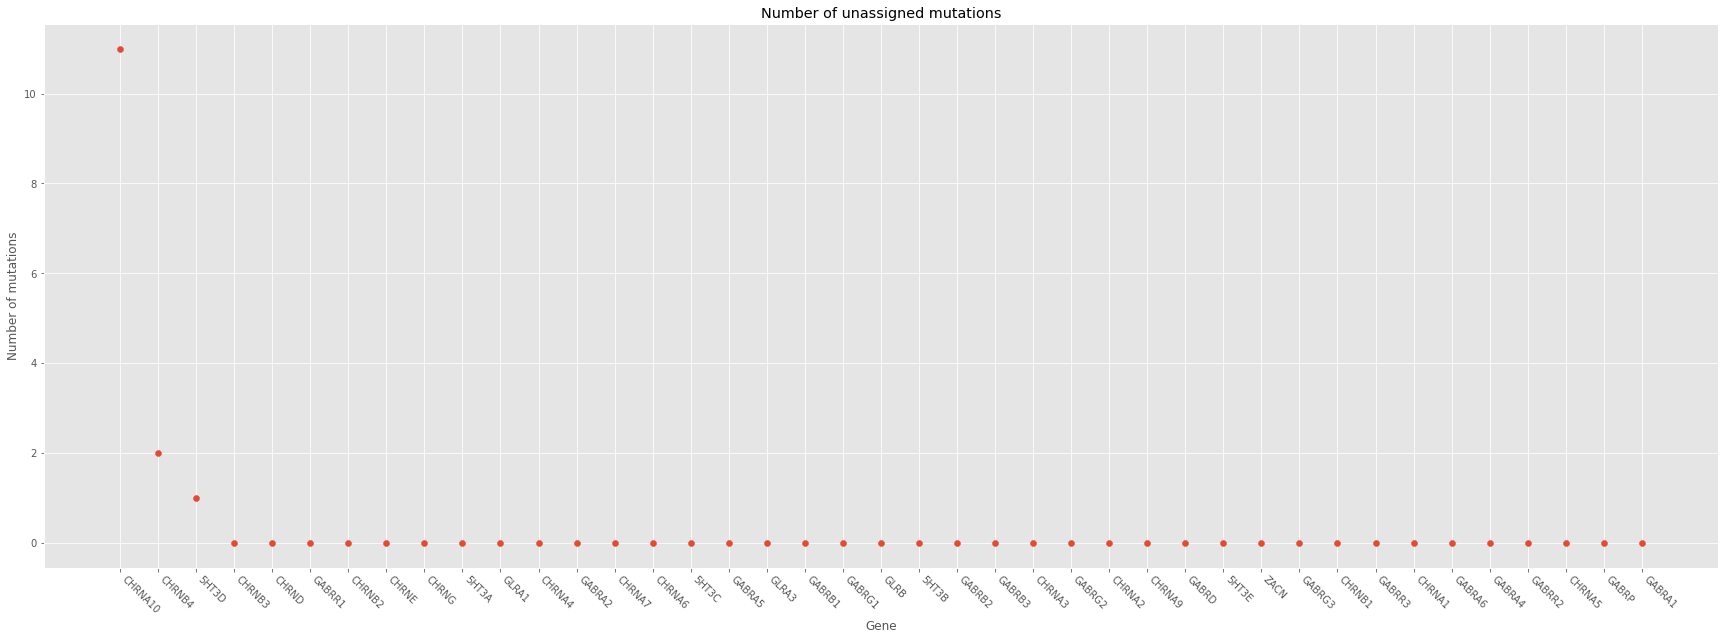

In [74]:
_values["AA Unreferenced"] = _values.apply(lambda x: -sum(missense["AA Referenced"][(missense["AA Referenced"] == -1) & (missense["Gene"] == x["Gene"])]), axis=1)
_values.sort_values(by="AA Unreferenced", ascending=False, inplace=True, ignore_index=True)

pyplot.scatter(_values["Gene"], _values["AA Unreferenced"])
pyplot.xticks(rotation=-45, horizontalalignment="left")
pyplot.xlabel("Gene")
pyplot.ylabel("Number of mutations")
pyplot.title("Number of unassigned mutations")
pyplot.show()

Let's see how this translates into the proportion of the individual gene mutations that are unasigned.

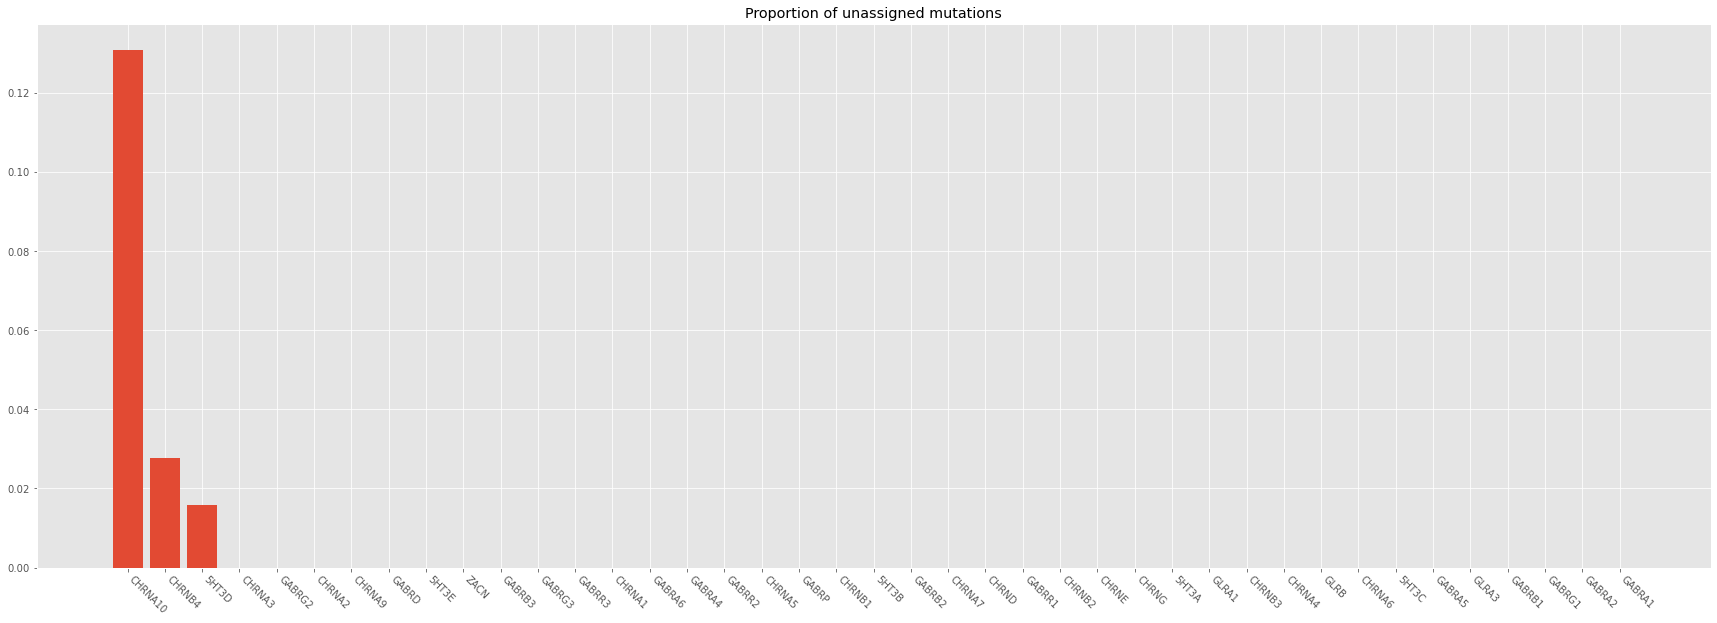

In [42]:
_values["AA Unreferenced"] = _values.apply(lambda x: -sum(missense["AA Referenced"][(missense["AA Referenced"] == -1) & (missense["Gene"] == x["Gene"])]) / sum(missense["Gene"] == x["Gene"]), axis=1)
_values.sort_values(by="AA Unreferenced", ascending=False, inplace=True, ignore_index=True)

pyplot.bar(_values["Gene"], _values["AA Unreferenced"])
pyplot.xticks(rotation=-45, horizontalalignment="left")
pyplot.title("Proportion of unassigned mutations")
pyplot.show()

**Note:**

- CHRNA10: has an extra protein coding transcript, which cannot be reliably áligned to the main transcript, so we cannot add it.
- CHRNB4: we already aligned all the transcript we could
- very short sequences (<100 AA) were automatically excluded

We have for now 0.9 % of SNPs where the numbering of amino acid was incorrect. We might reduce this through adding `extra sequences` or through `manual search`. Is the latter one worth it though?

For now we check where we find the variants in the reference sequence. There seem to be several hot spots. Note that the parts without signal don't necessarily mean a spot that is mutation-free, but might be a part of the protein that is tolerating the mutations better.

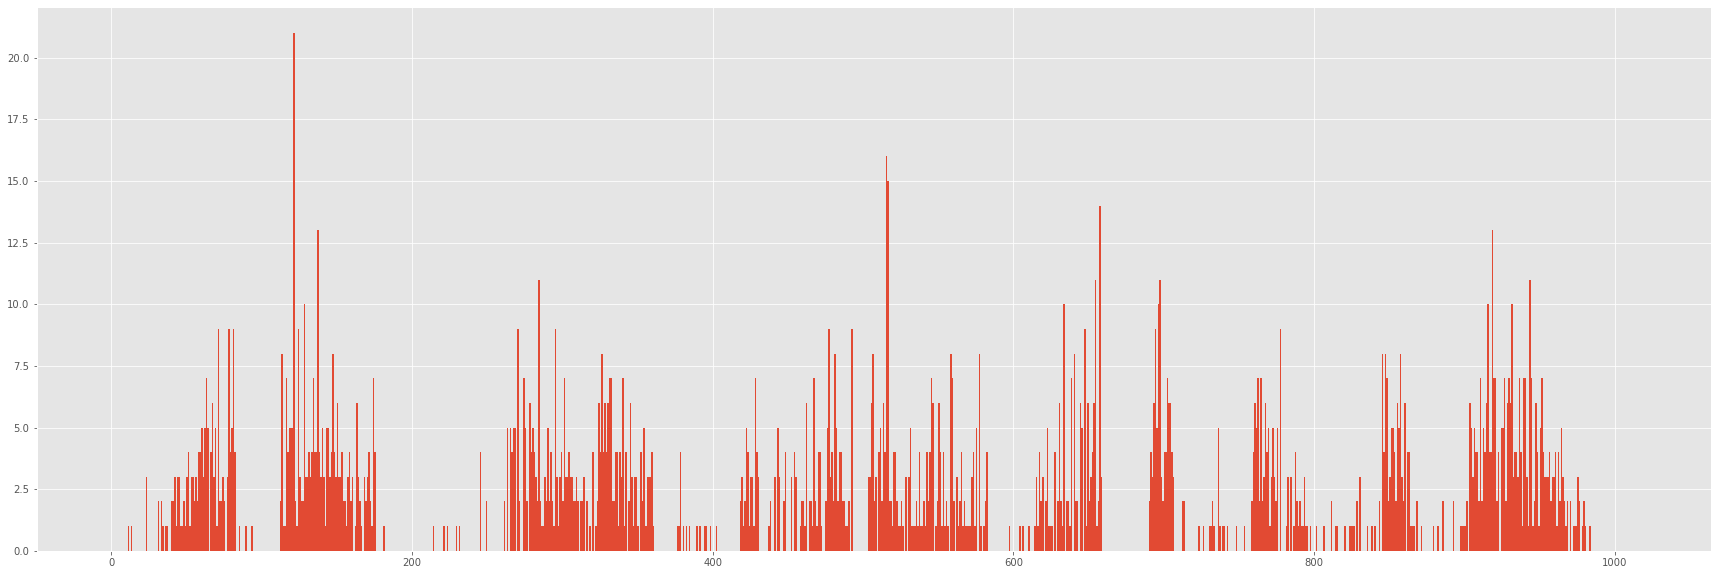

In [43]:
found_missense = missense[missense["AA Referenced"] != -1]
pyplot.hist(found_missense["AA Referenced"], bins=[x for x in range(1, len(alignment[0]))])
pyplot.show()

Just in case we will also take only one mutation per amino acid, so we can see where multiple genes get mutated.

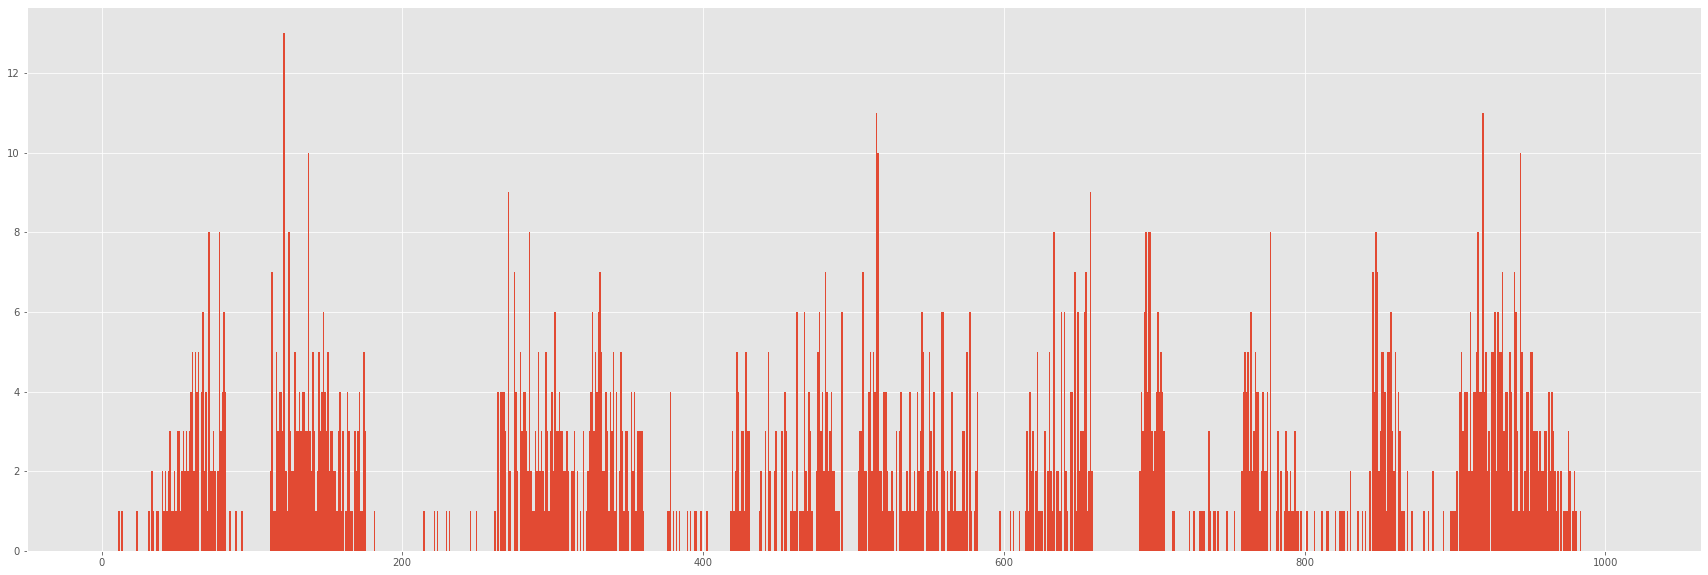

In [44]:
_unique_aas = []
for gene in found_missense["Gene"].unique():
    _unique_aas.extend(found_missense["AA Referenced"][found_missense["Gene"] == gene].unique())
pyplot.hist(_unique_aas, bins=[x for x in range(1, len(alignment[0]))])
pyplot.show()

## Mapping to structural elements
We have a list of the amino acids involved in the structural elements written in a CSV file. We load them in, transform them to the reference numbering and use them as a reference to annotate the table of mutations.

In [45]:
structural_elements = pandas.read_csv("Structural_elements.csv")
structural_elements

,Gene,AA Name,AA Number,BS
0,GABRB2,S,253,uTMD_principal_extended
1,GABRB2,I,256,uTMD_principal_extended
2,GABRB2,T,281,uTMD_principal_extended
3,GABRB2,V,282,uTMD_principal_extended
4,GABRB2,L,283,uTMD_principal_extended
...,...,...,...,...
444,GABRA1,S,417,ICD
445,GABRA1,K,418,ICD
446,GABRA1,I,419,ICD
447,GABRA1,D,420,ICD


In [46]:
structural_elements["AA Referenced"] = structural_elements.apply(lambda x: ali_class.convert_to_reference(x["Gene"], x["AA Name"], x["AA Number"]) , axis=1)
structural_elements

,Gene,AA Name,AA Number,BS,AA Referenced
0,GABRB2,S,253,uTMD_principal_extended,530
1,GABRB2,I,256,uTMD_principal_extended,533
2,GABRB2,T,281,uTMD_principal_extended,559
3,GABRB2,V,282,uTMD_principal_extended,560
4,GABRB2,L,283,uTMD_principal_extended,561
...,...,...,...,...,...
444,GABRA1,S,417,ICD,939
445,GABRA1,K,418,ICD,940
446,GABRA1,I,419,ICD,941
447,GABRA1,D,420,ICD,942


A quick look at the mutations in the core of uTMD site.

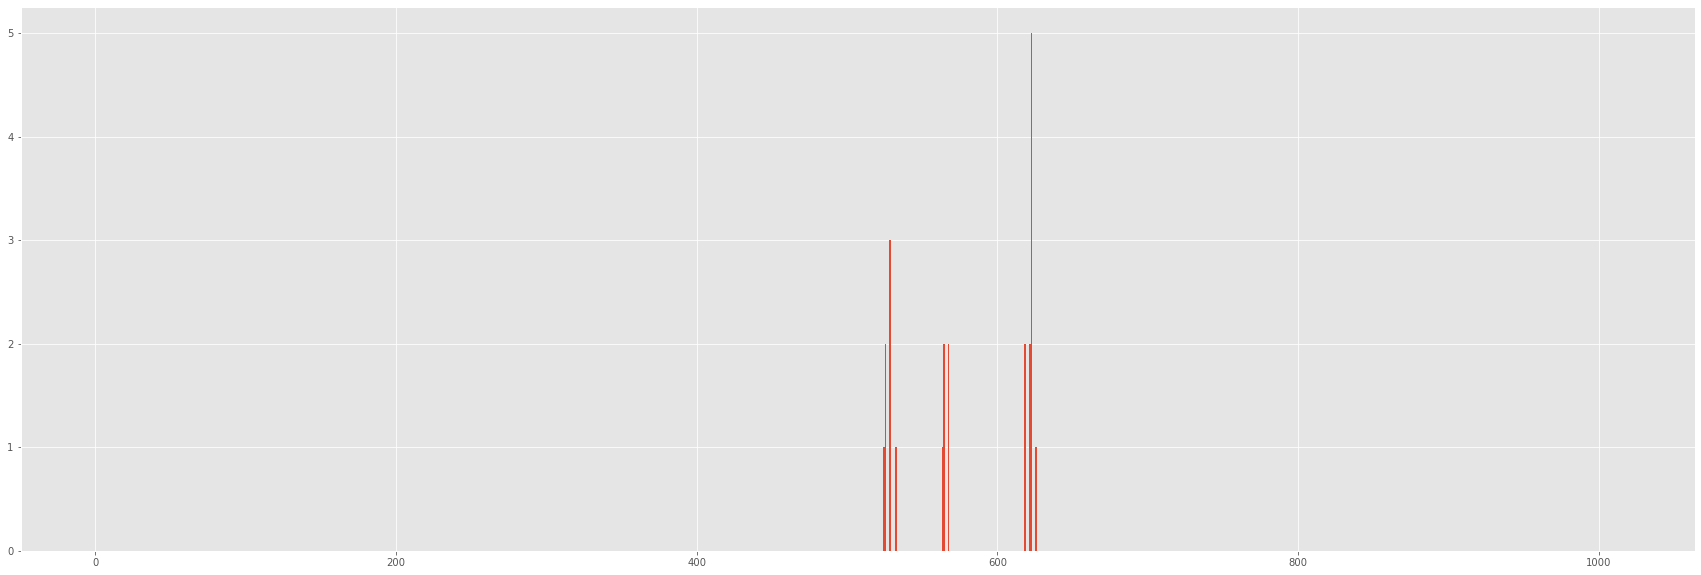

In [47]:
close_only = missense[missense["AA Referenced"].isin(structural_elements["AA Referenced"][structural_elements["BS"].isin(["uTMD_principal_close", "uTMD_complementary_close"])])]

pyplot.hist(close_only["AA Referenced"], bins=[x for x in range(1, len(alignment[0]))])
pyplot.show()

In [48]:
missense_annotated = pandas.merge(missense, structural_elements[["AA Referenced", "BS"]][~structural_elements["BS"].isin(("ECD", "TM1", "TM2", "TM3", "TM4", "ICD"))], how="left", on="AA Referenced")

In [49]:
missense_annotated = missense_annotated[~missense_annotated["BS"].isna()]
missense_annotated

,level_0,index,Chromosome,Position,rsIDs,Reference,Alternate,Source,Filters - exomes,Filters - genomes,...,Allele Count European (non-Finnish),Allele Number European (non-Finnish),Homozygote Count European (non-Finnish),Hemizygote Count European (non-Finnish),Gene,Transcript,AA Number,AA Relative,AA Referenced,BS
40,373,392,3,184105789.0,rs199689348,C,T,gnomAD Genomes,NaN,PASS,...,4.0,68040.0,0.0,0.0,5HT3E,NaN,249,0.546053,521.0,uTMD_complementary_extended
41,374,393,3,184105793.0,rs200508262,A,G,gnomAD Genomes,NaN,PASS,...,1.0,68022.0,0.0,0.0,5HT3E,NaN,250,0.548246,522.0,uTMD_complementary_extended
42,398,417,3,184105915.0,rs144049189,G,A,gnomAD Genomes,NaN,PASS,...,1.0,68026.0,0.0,0.0,5HT3E,NaN,291,0.638158,565.0,uTMD_principal_extended
44,412,431,3,184105963.0,rs143856984,C,G,gnomAD Genomes,NaN,PASS,...,1.0,68038.0,0.0,0.0,5HT3E,NaN,307,0.673246,616.0,uTMD_principal_extended
45,413,432,3,184105967.0,rs148605702,T,C,gnomAD Genomes,NaN,PASS,...,4.0,68002.0,0.0,0.0,5HT3E,NaN,308,0.675439,617.0,uTMD_principal_extended
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1928,26509,28386,3,184036392.0,NaN,C,A,gnomAD Genomes,NaN,PASS,...,0.0,68038.0,0.0,0.0,5HT3D,NaN,72,0.158590,535.0,uTMD_complementary_extended
1946,26653,28530,3,184038160.0,rs140918539,T,C,gnomAD Genomes,NaN,PASS,...,107.0,68010.0,0.0,0.0,5HT3D,NaN,219,0.482379,559.0,uTMD_principal_extended
1947,26654,28531,3,184038169.0,rs772424806,G,A,gnomAD Genomes,NaN,PASS,...,0.0,68024.0,0.0,0.0,5HT3D,NaN,222,0.488987,562.0,uTMD_principal_extended
1948,26657,28534,3,184038177.0,rs747381697,G,A,gnomAD Genomes,NaN,PASS,...,1.0,68022.0,0.0,0.0,5HT3D,NaN,225,0.495595,565.0,uTMD_principal_extended


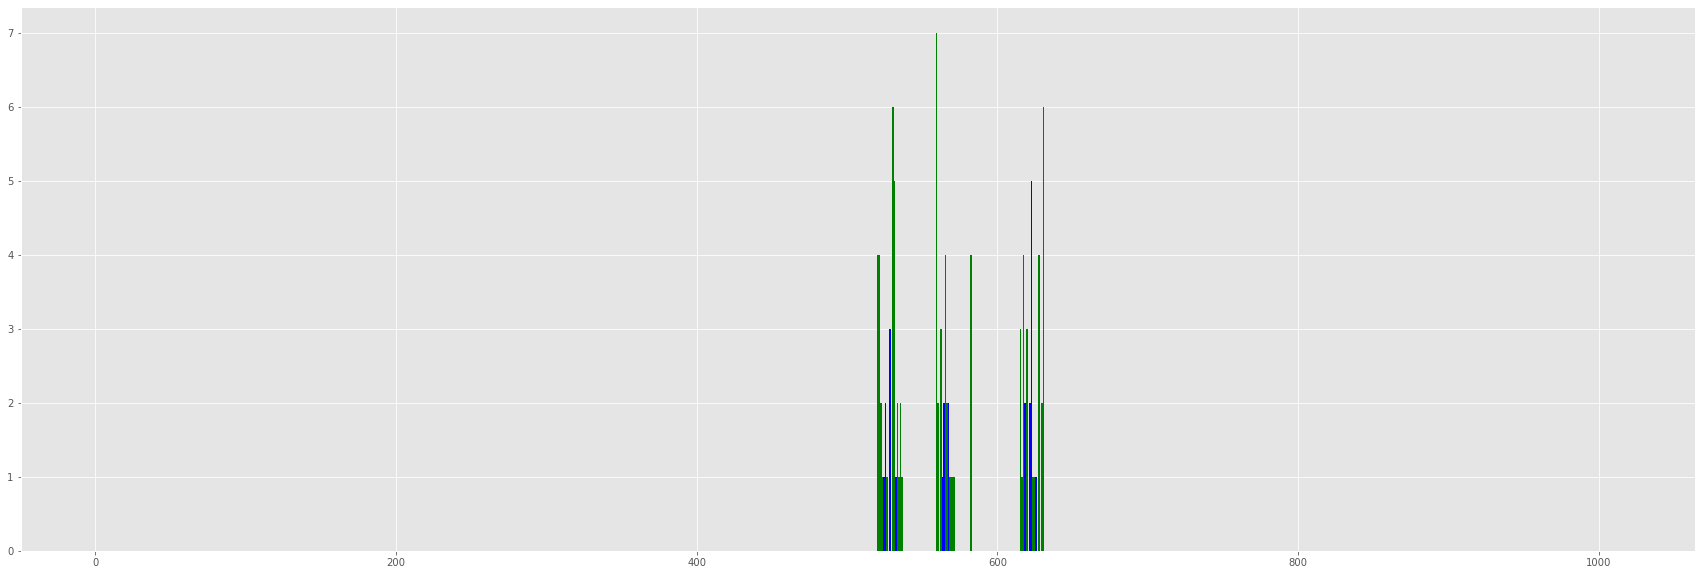

In [50]:
pyplot.hist(missense_annotated["AA Referenced"][missense_annotated["BS"].str.endswith("close")], bins=[x for x in range(1, len(alignment[0]))], color = "blue") 
pyplot.hist(missense_annotated["AA Referenced"][missense_annotated["BS"].str.endswith("extended")], bins=[x for x in range(1, len(alignment[0]))], color = "green")
pyplot.show()

In [51]:
missense_annotated["Allele Relative"] = missense_annotated["Allele Count"]/missense_annotated["Allele Number"]

In [52]:
missense_annotated.reset_index(inplace=True, drop=True)

In [53]:
print(*missense_annotated.duplicated(subset=["Gene", "AA Referenced"]).tolist(), sep="\n")

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
False
False
True
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
True
False
False
False
False
False
False
False
True
False
False
False
True
False
False
False
False
False
False
False
True
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False


Multiple mutations in a gene can map to the single codon. As such we will aggregate those into a single entry by summing up their frequencies. This is not necessarily completely correct, but in this case we don't have extra data that could help us make a better estimation.

In [54]:
missense_annotated_mini = missense_annotated[["Gene", "AA Referenced", "Allele Relative"]]
missense_annotated_mini = missense_annotated_mini.groupby(["Gene", "AA Referenced"]).sum()
missense_annotated_mini.reset_index(inplace=True)
missense_annotated_mini = missense_annotated_mini.pivot("Gene", "AA Referenced", "Allele Relative")
missense_annotated_mini[missense_annotated_mini.isna()] = 0

In [55]:
fig = px.imshow(missense_annotated_mini)
fig.show()